# Amazon fine food reviews:

### Data consists of 500,000 reviews from amazon fine food starting October 1999 to October 2012,

source https://snap.stanford.edu/data/web-FineFoods.html


- Are reviews from top food reviewers more helpful and receive more positive feedback from the community?
- Is there any trend in review score from 1999 to 2012?
- Is it possible to predict the sentiment of the review (positive/negative) using natural language processing?
- Is it possible to visualize any structure in the word collections in lower dimensions?

**First We want to know What is Amazon Fine Food Review Analysis?**

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories.
Amazon reviews are often the most publicly visible reviews of consumer products. As a frequent Amazon user, I was interested in examining the structure of a large database of Amazon reviews and visualizing this information so as to be a smarter consumer and reviewer.

# Introduction
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.



<img src="home.jpeg"></img>

<br>

## Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter
from tqdm import tqdm_notebook as tqdm

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from    keras.callbacks   import ModelCheckpoint 

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline


C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using Theano backend.


## Reading the data

Data has 500,000 rows and 10 columns, including productId, userId, review helpfulness score, score, timestamp (unix timestamp) and the review itself in one or multiple sentences.

- Id: Index of user in the system
- ProductId: Unique code associated with each product
- UserId: Unique code associated with each user
- HelpfulnessNumerator: number of users finding review helpful
- HelpfulnessDenominator: number of users checking the review
- Time: Unix stamp of review
- Summary: title of the review
- Text: review text

In [149]:
amz_review=pd.read_csv('Reviews.csv')

In [150]:
amz_review.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [151]:
amz_review.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## A sample review

In [152]:
amz_review['Text'][4]

'Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.'

In [153]:
amz_review['Summary'][4]

'Great taffy'

## Basic statistics on product and user number

In [154]:
print('Number of unique products:', len(amz_review['ProductId'].unique()))

Number of unique products: 74258


In [155]:
print('Number of unique users:', len(amz_review['UserId'].unique()))

Number of unique users: 256059


In [156]:
print('Estimate of number unique reviews:', len(amz_review['Text'].unique()))

Estimate of number unique reviews: 393579


In [157]:
len(amz_review['Summary'].unique())

295743

# Data pre-processing

## Check for repeated entries

A look at the data reveal that there are over 5800 entries that are repeated. Some Users simply edited their comments and the record is kept multiple time. This repetition needs to be cleaned.

In [158]:
# grouping the data by user and product to check for repeatability
amz_review.groupby(by=['UserId','ProductId']).count().sort_values(by=['Text'],ascending=False).head(5)

Id  ProfileName  HelpfulnessNumerator  \
UserId         ProductId                                           
A29JUMRL1US6YP B000WFKWDI  11           11                    11   
               B000WFU8O6  11           11                    11   
               B000WFN0VO  11           11                    11   
               B000WFORH0  11           11                    11   
               B000WFKI82  11           11                    11   

                           HelpfulnessDenominator  Score  Time  Summary  Text  
UserId         ProductId                                                       
A29JUMRL1US6YP B000WFKWDI                      11     11    11       11    11  
               B000WFU8O6                      11     11    11       11    11  
               B000WFN0VO                      11     11    11       11    11  
               B000WFORH0                      11     11    11       11    11  
               B000WFKI82                      11     11    11       11    11

In [159]:
# number of total repetition in data
((amz_review.groupby(by=['UserId','ProductId']).count().sort_values(by=['Text'],ascending=False)>1)==True).sum()

Id                        5859
ProfileName               5859
HelpfulnessNumerator      5859
HelpfulnessDenominator    5859
Score                     5859
Time                      5859
Summary                   5859
Text                      5859
dtype: int64

In [160]:
print('Initial size')
amz_review.shape

Initial size


(568454, 10)

In [161]:
# droppping duplicate only keeping one per case
amz_review_sorted_drop_duplicated=amz_review.drop_duplicates(subset=['UserId','ProductId'], keep='first', inplace=False)

In [162]:
# repeated offenders removed
((amz_review_sorted_drop_duplicated.groupby(by=['UserId','ProductId']).count().sort_values(by=['Text'],ascending=False)>1)==True).sum()

Id                        0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [163]:
print('Size after removing duplicate review')
amz_review_sorted_drop_duplicated.shape

Size after removing duplicate review


(560804, 10)

In [164]:
amz_review_sorted_drop_duplicated.shape

(560804, 10)

## Converting the Unix time to actual time

In [165]:
# converting unix time to year/month/day format, hour/min/sec is not available
amz_review_sorted_drop_duplicated['Time_converted']=amz_review_sorted_drop_duplicated['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m-%d'))
#strftime('%Y-%m-%d %H:%M:%S'))
amz_review_sorted_drop_duplicated['Time_converted_ym']=amz_review_sorted_drop_duplicated['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

In [166]:
print('Earliest review')
amz_review_sorted_drop_duplicated['Time_converted'].min()

Earliest review


'1999-10-08'

In [167]:
print('latest review')
amz_review_sorted_drop_duplicated['Time_converted'].max()

latest review


'2012-10-26'

# Preprocessing Using NLTK Libraries and machine learning skills on text data

But here is the Problem we can see that in our dataset we have columns of text and summary. These are text features but in machine learning we want to use only numerical features for building model. Now, the question is how to convert Text features into numerical vectors?

In [172]:
df = amz_review_sorted_drop_duplicated


In [173]:
df[df['Score'] != 3]
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Time_converted,Time_converted_ym,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011-04,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008-08,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011-06,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012-10,1


Now, let’s split our data into random training and test subsets using “Text” and “Positivity” columns, and then print out the first entry and the shape of the training set.

In [ ]:
feature_names = np.array(vect.get_feature_names())
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
print('Smallest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Positivity'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)


X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (420603,)
X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (420603,)


# Bags-of-words
The simplest and most intuitive way to do so, is the “bags-of-words” representation which ignores structure and simply counts how often each word occurs. CountVectorizer allows us to use the bags-of-words approach, by converting a collection of text documents into a matrix of token counts.
We instantiate the CountVectorizer and fit it to our training data, converting our collection of text documents into a matrix of token counts.

In [175]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

This model has many parameters, however the default values are quite reasonable for our purpose.
The default configuration tokenizes the string, by extracting words of at least 2 letters or numbers, separated by word boundaries, it then converts everything to lowercase and builds a vocabulary using these tokens. We can get some of the vocabularies by using the get_feature_names method like so:

In [176]:
vect.get_feature_names()[::2000]

['00',
 '24qt',
 '85c',
 'aftertraste',
 'antica',
 'aviable',
 'b000micpsa',
 'b001sawhpm',
 'b005k4q4lk',
 'bellagio',
 'boorish',
 'byalbanese',
 'celestials',
 'cincy',
 'concerend',
 'crazies',
 'decomposition',
 'diluted',
 'drools',
 'endurox',
 'explorers',
 'flaover',
 'fryed',
 'glycoside',
 'habbits',
 'hitek',
 'impeded',
 'iran',
 'kens',
 'leavening',
 'luna',
 'mccann',
 'mivie',
 'nanoparticles',
 'nutriotional',
 'outcome',
 'pearled',
 'plasticsindustry',
 'price',
 'quinn',
 'regularlly',
 'rnaise',
 'scape',
 'shipd',
 'snarfs',
 'sr_1_6',
 'suger',
 'tasteless',
 'tisane',
 'tutorials',
 'uptick',
 'waistbands',
 'wolfberries']

Looking at those vocabularies, we can get a small sense of what they are about . By checking the length of get_feature_names, we can see that we’re working with 105956 features.

In [177]:
len(vect.get_feature_names())

105956

Next, we transform the documents in X_train to a document term matrix, which gives us the bags-of-word representation of X_train. The result is stored in a SciPy sparse matrix, where each row corresponds to a document, and each column is a word from our training vocabulary.

In [178]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<420603x105956 sparse matrix of type '<class 'numpy.int64'>'
	with 22540636 stored elements in Compressed Sparse Row format>

# Logistic Regression
Now, we will train the Logistic Regression classifier based on this feature matrix X_ train_ vectorized, because Logistics Regression works well for high dimensional sparse data.


In [184]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

C:\Python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Next, we’ll make predictions using X_test, and compute the area under the curve score.

In [185]:
from sklearn.metrics import roc_auc_score
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8418142654570803


The result is not bad. In order to better understand how our model makes these predictions, we can use the coefficients for each feature (a word) to determine its weight in terms of positivity and negativity.

In [186]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['quickness' 'weiner' 'ripoff' 'dissapointing' 'realllly' 'jamming'
 'worst' 'unimpressed' 'amendment' 'chasen']

Largest Coefs: 
['emeraldforest' 'chedder' 'blowout' 'hears' 'bertie' 'addicting' 'hooked'
 'deducting' 'hahaha' 'overeating']



Sorting the ten smallest and ten largest coefficients, we can see the model has predicted words like “worst”, “disappointing” and “horrible” to negative reviews, and words like “hooked”, “bright”, and “delicious” to positive reviews.
However, our model can be improved.

# Tf–idf term weighting

In a large text corpus, some words will be present very often but will carry very little meaningful information about the actual contents of the document (such as “the”, “a” and “is”). If we were to feed the count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms. Tf-idf allows us to weight terms based on how important they are to a document.

So, we will instantiate the tf–idf vectorizer and fit it to our training data. We specify min_df = 5, which will remove any words from our vocabulary that appear in fewer than five documents.

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

36441

In [188]:
X_train_vectorized = vect.transform(X_train)
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

C:\Python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC:  0.8314771212598884


So, although we were able to reduce the number of features from 105956 to just 36441, our AUC score dropped by almost 1%.

Using the following code, we are able to obtain a list of features with the smallest tf-idf that either commonly appeared across all reviews or only appeared rarely in very long reviews and a list of features with the largest tf–idf contains words which appeared frequently in a review, but did not appear commonly across all reviews.

In [189]:
feature_names = np.array(vect.get_feature_names())
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
print('Smallest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest Tfidf: 
['amortization' 'furnishings' '0373' '0377' '1534' '0004' 'isoleucine2'
 'debittered' 'tryptophan1' 'serine']

Largest Tfidf: 
['1100' 'carmel' '98' 'yum' 'aaa' 'good' 'filler' 'word' 'mmm' 'awesome']



In [190]:
print(model.predict(vect.transform(['The candy is not good, I will never buy them again','The candy is not bad, I will buy them again'])))

[1 0]


Our current model misclassified the document “The candy is not good, I will never buy them again” as a positive review, and it also misclassified the document “The candy is not bad, I will buy them again” as a negative review.

# n-grams
One way to fix this misclassification is to add n-grams. For example, bigrams count pairs of adjacent words, and could give us features such as bad versus not bad. Thus, we are refitting our training set specifying a minimum document frequency of 5, and extracting 1-grams and 2-grams.

In [191]:
vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
len(vect.get_feature_names())

557018

Now we get a lot more features to work with but our AUC score increased to 90%

In [192]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

C:\Python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC:  0.9091032712924052


Using the coefficients to check each feature, we can see

In [193]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:10]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-11:-1]))

Smallest Coef: 
['three stars' 'two stars' 'not worth' 'not recommend' 'disappointing'
 'no thanks' 'not happy' 'at best' 'worst' 'not impressed']

Largest Coef: 
['four stars' 'not disappointed' 'be disappointed' 'just right' 'hooked'
 'addicting' 'not bitter' 'you won' 'love it' 'been disappointed']



Our new model has correctly predicted bigrams like “not recommend”, “not worth” to negative reviews, and bigrams like “not bitter”, “not disappointed” to positive reviews.
Let’s test our new model:

In [195]:
print(model.predict(vect.transform(['The candy is not good, I would never buy them again','The candy is not bad, I will buy them again'])))

[0 1]


Our latest model now correctly identifies them as negative and positive reviews respectively.

# Preprocessing Using without using NLTK Libraries

## Cleaning the text of reviews (multiple steps)

- Removing partially scraped containing html headers, and lower case the text
- Remove special characters (e.g. "{$1?&") from the text
- Removing extra space, parsing the data
- Removing stopwords (e.g. " he, she, is, the,..."), keep reviews with at least 3 word
- Removing NaN (very few)

### Removing partially scraped html from data

In [23]:

def clean_span(col):  
    
    ''' This function clean the partially scraped html data "<span" from each input after lower case conversion
    
    Input:
    
    col: text from cell of a dataframe
    
    Return:
    
    clean (no "<span") /lower case text
    '''
    
    
    if('<span' not in col.lower()):

        return col.lower()

In [24]:
amz_review_sorted_drop_duplicated['Text_new']=amz_review_sorted_drop_duplicated['Text'].apply(clean_span)
amz_review_sorted_drop_duplicated['Text_new']

0         i have bought several of the vitality canned d...
1         product arrived labeled as jumbo salted peanut...
2         this is a confection that has been around a fe...
3         if you are looking for the secret ingredient i...
4         great taffy at a great price.  there was a wid...
                                ...                        
568449    great for sesame chicken..this is a good if no...
568450    i'm disappointed with the flavor. the chocolat...
568451    these stars are small, so you can give 10-15 o...
568452    these are the best treats for training and rew...
568453    i am very satisfied ,product is as advertised,...
Name: Text_new, Length: 560804, dtype: object

In [25]:
amz_review_sorted_drop_duplicated.isnull().sum()


Id                          0
ProductId                   0
UserId                      0
ProfileName                16
HelpfulnessNumerator        0
HelpfulnessDenominator      0
Score                       0
Time                        0
Summary                    27
Text                        0
Time_converted              0
Time_converted_ym           0
Text_new                  373
dtype: int64

### Removing NaNs

In [26]:
# data is removed from very few NaNs
amz_review_sorted_drop_duplicated.dropna(inplace=True)

### Removing English stop words and special characters from reviews


In [27]:
stop_word_list =[]
for word in open('stopword_short_long_mod.txt'):

    stop_word_list.append(word.replace('\n',''))
    
stop_word_list=list(set(stop_word_list))   
print('stop word length', len(stop_word_list))

special_char_list=['\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']

         
                
def remove_specialchar(col):
    
    
    ''' This function remove special characters "#, %, 1,&,.", and extra space which have no particular effect of sentiment
    analysis, 
    
    Input:
    
    col: text (string)
    
    Return:
    
    clean text without special character and extra spce
    '''    
        
    for word in special_char_list:
            
        if word in col: 
            col=col.replace(word,"").replace("  "," ")
                

    return col                  
    
def remove_stopword(col):
    

    
    ''' This function remove stopwords "he, she, is, that, the" which have no particular effect of sentiment
    analysis, parse the data, remove "\n", and keep reviews with more than 3 words
    
    Input:
    
    col: text from cell of a dataframe
    
    Return:
    
    list of parsed words from each review
    '''
    
        
    col_list=[]
    txt_col_split=col.lower().replace('\n'," ").strip().split(" ")
        
    for word_ in txt_col_split:
              
        if ((word_ not in stop_word_list) and len(word)>3):
                
            col_list.append(word_)

    return (col_list) 

stop word length 642


In [28]:
# applying special character removal to dataframe
amz_review_sorted_drop_duplicated['Text_new2']=amz_review_sorted_drop_duplicated['Text_new'].apply(remove_specialchar)

In [29]:
# applying stop words removal to dataframe
amz_review_sorted_drop_duplicated['Text_new2']=amz_review_sorted_drop_duplicated['Text_new2'].apply(remove_stopword)

### Example of parsed and cleaned review

In [30]:
#  A list of cleans words is the output
print(amz_review_sorted_drop_duplicated['Text_new2'][0])

['bought', 'vitality', 'canned', 'dog', 'food', 'products', 'good', 'quality', 'product', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


# Exploratory Data Analysis

## Calculating review lengths

- Length of review is calculated (after cleaning) to understand impact of more in depth content on its helpfulness
- Reviews on average have about 80 words, very small <1% go beyond 400 words

In [31]:
# lenght of review calculated stored in new column
amz_review_sorted_drop_duplicated['Text_lenght']=amz_review_sorted_drop_duplicated['Text'].apply(lambda col: len(col.split(' ')))

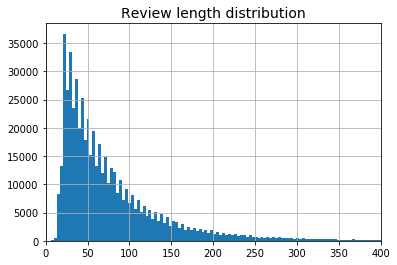

In [32]:
amz_review_sorted_drop_duplicated['Text_lenght'].hist(bins=1000);
plt.xlim(0,400)
plt.title('Review length distribution',fontsize=14);

In [33]:
amz_review_sorted_drop_duplicated['Text_lenght'].describe()

count    560388.000000
mean         81.332177
std          79.101098
min           3.000000
25%          34.000000
50%          57.000000
75%          99.000000
max        3526.000000
Name: Text_lenght, dtype: float64

In [34]:
# data checked again, no Nan observed
amz_review_sorted_drop_duplicated.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Time_converted            0
Time_converted_ym         0
Text_new                  0
Text_new2                 0
Text_lenght               0
dtype: int64

## A look at the review scores

- Checking the count of the reviews for each score
- Ratio of reviews with score 5 are disproportional to the rest of reviews, with 3 to 1 ratio
- This high count of "5" star reviews will be revisited again with trend with time is addressed in later section

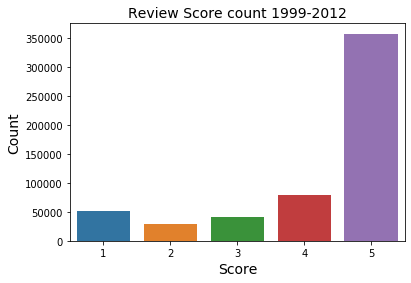

In [35]:
# plotting count of each review star
sns.countplot(x='Score', data=amz_review_sorted_drop_duplicated);
plt.xlabel('Score',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review Score count 1999-2012',fontsize=14);
plt.savefig('review_score_count_1999_2012.png')

In [36]:
def score_pos_neg(col):
    
    ''' This function get the score between 1 to five and return 1 for score>3 and return 0 for score<3,
    as positive and negative respectively
    
    Input:
    
    col: number between 1 to 5 (review star)
    
    Return:
    
    return 1 or 0
    '''
    
    if col>3:
        return 1
    else:
        return 0

amz_review_sorted_drop_duplicated['score_pos_neg']=amz_review_sorted_drop_duplicated['Score'].apply(score_pos_neg)


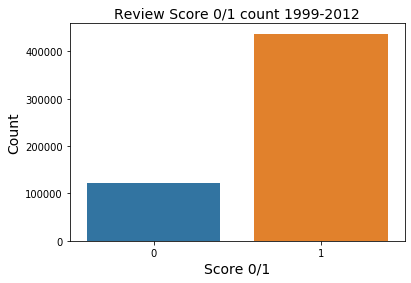

In [37]:
#plotting count of positive "1" and negative "0" reviews
sns.countplot(x='score_pos_neg', data=amz_review_sorted_drop_duplicated);
plt.xlabel('Score 0/1',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review Score 0/1 count 1999-2012',fontsize=14);
plt.savefig('review_score_01count_1999_2012.png')

In [38]:
# parsed and cleaned data is saved in csv file
amz_review_sorted_drop_duplicated.to_csv('amazon_review_parsed.csv',index=False)

## A look at top reviewer population (individuals with more than 10 reviews)

- Top reviewer are group of users to have spent more time reviewing the products and expected to have more engagement with the community, impact of this engagement effectiveness is studied in terms of feedback they receive from the community fortheir review 
- Individual with more than 10 review are in top review group, regardless of number of products
- Total review count per each user is analyzed against their average review helpfulness,as well as average review length


In [39]:
# total review per user is grouped
user_number_review=amz_review_sorted_drop_duplicated.groupby(by=['UserId']).count().sort_values(by=['Text'],ascending=False)

user_number_review.head()

,Id,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Time_converted,Time_converted_ym,Text_new,Text_new2,Text_lenght,score_pos_neg
UserId,,,,,,,,,,,,,,,
A3OXHLG6DIBRW8,419,419,419,419,419,419,419,419,419,419,419,419,419,419,419
AY12DBB0U420B,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382
A281NPSIMI1C2R,321,321,321,321,321,321,321,321,321,321,321,321,321,321,321
A1YUL9PCJR3JTY,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308
A1Z54EM24Y40LL,251,251,251,251,251,251,251,251,251,251,251,251,251,251,251


In [40]:
# only individual with moe than 10 review incuded in top group
user_top_reviewer=user_number_review[user_number_review['Id']>10][['Id']]
user_top_reviewer.head(10)   #11 to 419

,Id
UserId,
A3OXHLG6DIBRW8,419
AY12DBB0U420B,382
A281NPSIMI1C2R,321
A1YUL9PCJR3JTY,308
A1Z54EM24Y40LL,251
A2MUGFV2TDQ47K,201
AZV26LP92E6WU,167
AQQLWCMRNDFGI,167
A1UQBFCERIP7VJ,157


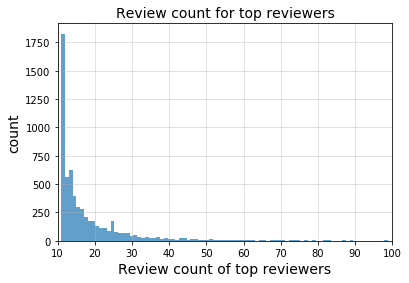

In [41]:
# distribution of review count per user

user_top_reviewer['Id'].hist(bins=400,label='Number of reviews for Top (>10) reviewer',alpha=0.7);
plt.xlabel('Review count of top reviewers',fontsize=14);
plt.ylabel('count',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)

plt.xlim(10,100)
plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('review_count__top_reviewer_dist.png')

In [42]:
user_top_reviewer['Id'].describe()

count    6098.000000
mean       19.741391
std        17.374368
min        11.000000
25%        12.000000
50%        15.000000
75%        21.000000
max       419.000000
Name: Id, dtype: float64

In [43]:
user_top_reviewer.to_csv('amazon_top_reviewer_list.csv')

In [44]:
# getting average data per user
user_average_info=amz_review_sorted_drop_duplicated.groupby(by=['UserId']).mean() 

In [45]:
user_average_info.to_csv('amazon_reviewer_avg_info.csv')

On average top reviewers write about 20 reviews, with very few <1% write over 40 review

### Getting the average statistics for top reviewers

In [46]:
# merging total review count and avg data per user
top_reviewer_avg_data=pd.merge(user_average_info,user_top_reviewer,how='inner',on='UserId')

In [47]:
user_top_reviewer.head()

,Id
UserId,
A3OXHLG6DIBRW8,419
AY12DBB0U420B,382
A281NPSIMI1C2R,321
A1YUL9PCJR3JTY,308
A1Z54EM24Y40LL,251


In [48]:
user_average_info.head()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg
UserId,,,,,,,
#oc-R103C0QSV1DF5E,136323.0,1.0,2.0,5.0,1.343088e+09,56.0,1.0
#oc-R109MU5OBBZ59U,516062.0,0.0,1.0,5.0,1.350086e+09,21.0,1.0
#oc-R10LFEMQEW6QGZ,516079.0,0.0,1.0,5.0,1.345939e+09,85.0,1.0
#oc-R10LT57ZGIB140,378693.0,0.0,0.0,3.0,1.310602e+09,45.0,0.0
#oc-R10UA029WVWIUI,136545.0,0.0,0.0,1.0,1.342483e+09,66.0,0.0


In [49]:
# calculate rtio of helpfulness, average number of people finding review helpful over total count commented on review
top_reviewer_avg_data['ratio_helpful']=top_reviewer_avg_data['HelpfulnessNumerator']/top_reviewer_avg_data['HelpfulnessDenominator']

In [50]:
top_reviewer_avg_data['Time_converted']=top_reviewer_avg_data['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

In [51]:
#making sure ratio of helpfulness between 0-1

top_reviewer_avg_data=top_reviewer_avg_data[(top_reviewer_avg_data['ratio_helpful']>0.0) & (top_reviewer_avg_data['ratio_helpful']<1.0)]

In [52]:
colors = np.random.rand(top_reviewer_avg_data.shape[0])

In [53]:
top_reviewer_avg_data.head()

,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Id_y,ratio_helpful,Time_converted
UserId,,,,,,,,,,
A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,166.418182,0.400000,55,0.345865,2011-09
A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,287.923077,0.346154,26,0.209302,2012-06
A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,91.272727,0.909091,11,0.666667,2009-05
A105S56ODHGJEK,296723.888889,0.111111,0.555556,3.222222,1.286256e+09,159.666667,0.444444,18,0.200000,2010-10
A106Q1A6LGU4DP,225461.307692,2.615385,2.846154,4.307692,1.322106e+09,149.538462,0.769231,13,0.918919,2011-11


## Review helpfulness distribution for top reviewers

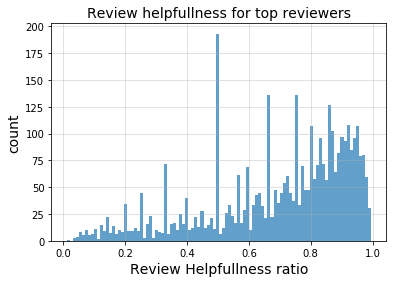

In [54]:
# review helpfulness distribution
top_reviewer_avg_data['ratio_helpful'].hist(bins=100,label='review helpfullness top reviewers',alpha=0.7);

plt.xlabel('Review Helpfullness ratio',fontsize=14);
plt.ylabel('count',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review helpfullness for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_dist.png')

Majority of people find top reviewer helpful 

## Review helpfulness vs. review length for top reviewers

In [55]:
top_reviewer_avg_data.head()

,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Id_y,ratio_helpful,Time_converted
UserId,,,,,,,,,,
A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,166.418182,0.400000,55,0.345865,2011-09
A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,287.923077,0.346154,26,0.209302,2012-06
A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,91.272727,0.909091,11,0.666667,2009-05
A105S56ODHGJEK,296723.888889,0.111111,0.555556,3.222222,1.286256e+09,159.666667,0.444444,18,0.200000,2010-10
A106Q1A6LGU4DP,225461.307692,2.615385,2.846154,4.307692,1.322106e+09,149.538462,0.769231,13,0.918919,2011-11


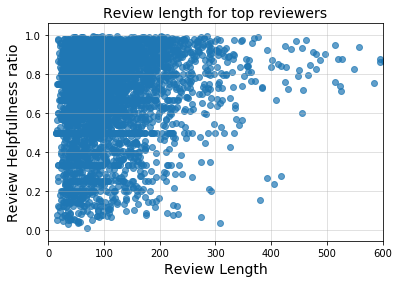

In [56]:
# review length vs helpfulness
plt.scatter(top_reviewer_avg_data['Text_lenght'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,600);
plt.xlabel('Review Length',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);
#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review length for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length.png')

Users generally find top reviewer with more than 200 words length review helpful, longer review better feedback

## Review helpfulness vs. review count for top reviewers

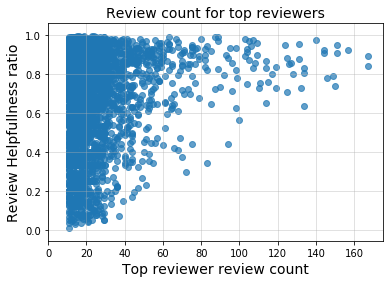

In [57]:
#review helpfulness vs. review count
plt.scatter(top_reviewer_avg_data['Id_y'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,175);
plt.xlabel('Top reviewer review count',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_count.png')

Top reviewers that write more frequent over 60 review (even though not many of them in dataset), receive very good feedback from community. If the review write between 1-30 words no trend observed though.

## Review frequency vs. review length for top reviewers

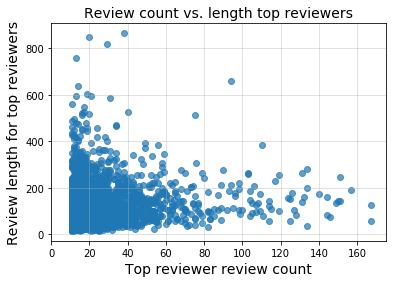

In [58]:
#revire count of top reviewers vs. review length
plt.scatter(top_reviewer_avg_data['Id_y'],top_reviewer_avg_data['Text_lenght'],alpha=0.7); #,c=top_reviewer_avg_data['ratio_helpful'])
plt.xlim(0,175);

plt.xlabel('Top reviewer review count',fontsize=14);
plt.ylabel('Review length for top reviewers',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review count vs. length top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length_count.png')

Interestingly the top reviewers that write more often do not write very long paragraphs above 200 words, while those that write longer have less than 20-30 review

# Review score/length/helfulness trend in time

- Here the impact of time on review score, length, and helpfulness is studied
- Data are grouped by score, as well as total count per month of each year from 1999 to 2012

In [59]:
# Divide the data by score and group for each month
grp_s1=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==1]
grp_s2=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==2]
grp_s3=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==3]
grp_s4=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==4]
grp_s5=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==5]

grp_date_1=grp_s1.groupby(by=['Time_converted_ym']).count();
grp_date_2=grp_s2.groupby(by=['Time_converted_ym']).count();
grp_date_3=grp_s3.groupby(by=['Time_converted_ym']).count();
grp_date_4=grp_s4.groupby(by=['Time_converted_ym']).count();
grp_date_5=grp_s5.groupby(by=['Time_converted_ym']).count();

grp_date_1.reset_index(inplace=True); #to make it to column
grp_date_2.reset_index(inplace=True);
grp_date_3.reset_index(inplace=True);
grp_date_4.reset_index(inplace=True);
grp_date_5.reset_index(inplace=True);

C:\Python\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Python\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Python\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


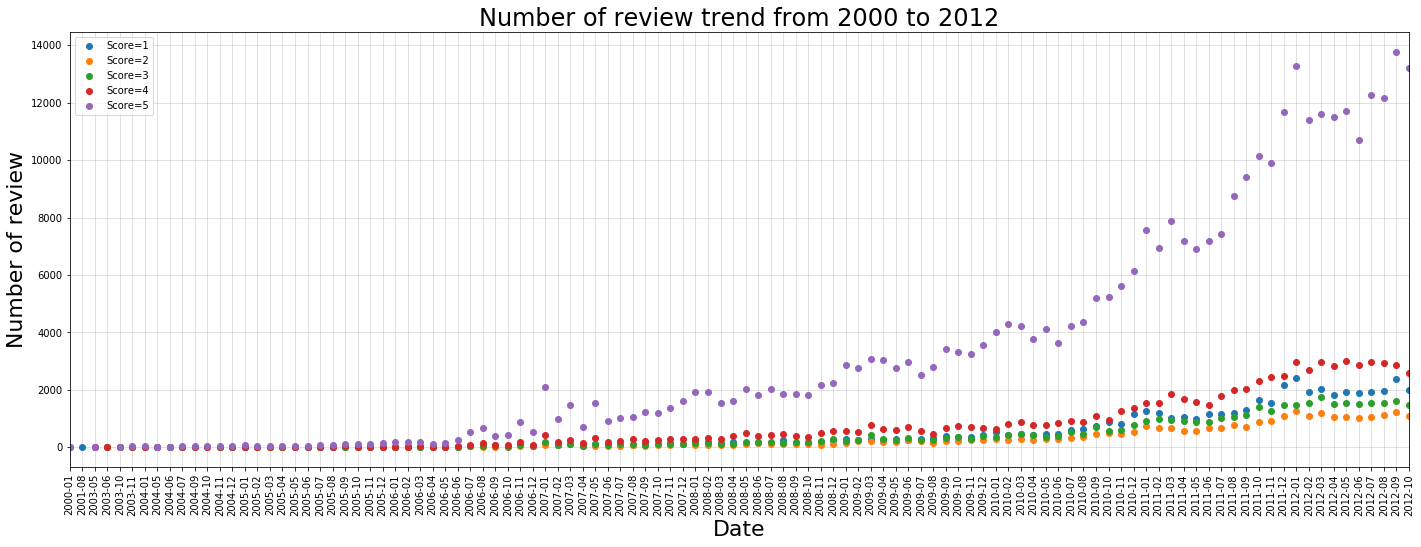

In [60]:
# review count by score for each month from 2000 to 2012
plt.figure(figsize=(24,8))

plt.plot_date(x=grp_date_1['Time_converted_ym'],y=grp_date_1['Score'],label='Score=1');
plt.plot_date(x=grp_date_2['Time_converted_ym'],y=grp_date_2['Score'],label='Score=2');
plt.plot_date(x=grp_date_3['Time_converted_ym'],y=grp_date_3['Score'],label='Score=3');
plt.plot_date(x=grp_date_4['Time_converted_ym'],y=grp_date_4['Score'],label='Score=4');
plt.plot_date(x=grp_date_5['Time_converted_ym'],y=grp_date_5['Score'],label='Score=5');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Number of review trend from 2000 to 2012',fontsize=24);
plt.savefig('data_review_trend.png')
#grp_date

- From the 2000 to 2006 there is limited review available on Amazon, however trend start to change suddenly after 2006, the total number of 5 star review show biggest surge among other scores, this seems a bit unusual and one might ask people generally are optimistic or most possibly there are unverified accounts that are boosting the seller inappropriately with fake reviews
- Another interesting observation even though minimal, during January 2007,2008,2011 and 2012 slight increase in 5 start reviews are observed. Question is this slight increase due to cheerful holiday spirit?! 
- The 1 to 4 star review count gradual increase make more sense due to more customer become aware of Amazon services.

In [61]:
# average of helpfulness per month is calculated
grp_avg_date=amz_review_sorted_drop_duplicated.groupby(by=['Time_converted_ym']).mean()
grp_avg_date.reset_index(inplace=True);
grp_avg_date['Helpfulness_ratio']=grp_avg_date['HelpfulnessNumerator']/grp_avg_date['HelpfulnessDenominator']

In [62]:
grp_avg_date.head()

,Time_converted_ym,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Helpfulness_ratio
0,1999-10,150512.500000,1.000,1.000,5.0,940075200.0,81.50,1.000,1.000000
1,1999-12,377094.500000,0.750,1.500,5.0,944352000.0,35.75,1.000,0.500000
2,2000-01,330241.500000,7.875,9.375,3.5,947797200.0,51.00,0.625,0.840000
3,2000-02,352267.666667,2.000,3.000,4.0,951523200.0,244.00,1.000,0.666667
4,2000-06,211823.600000,3.400,4.800,5.0,960785280.0,42.60,1.000,0.708333


C:\Python\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Python\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Python\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


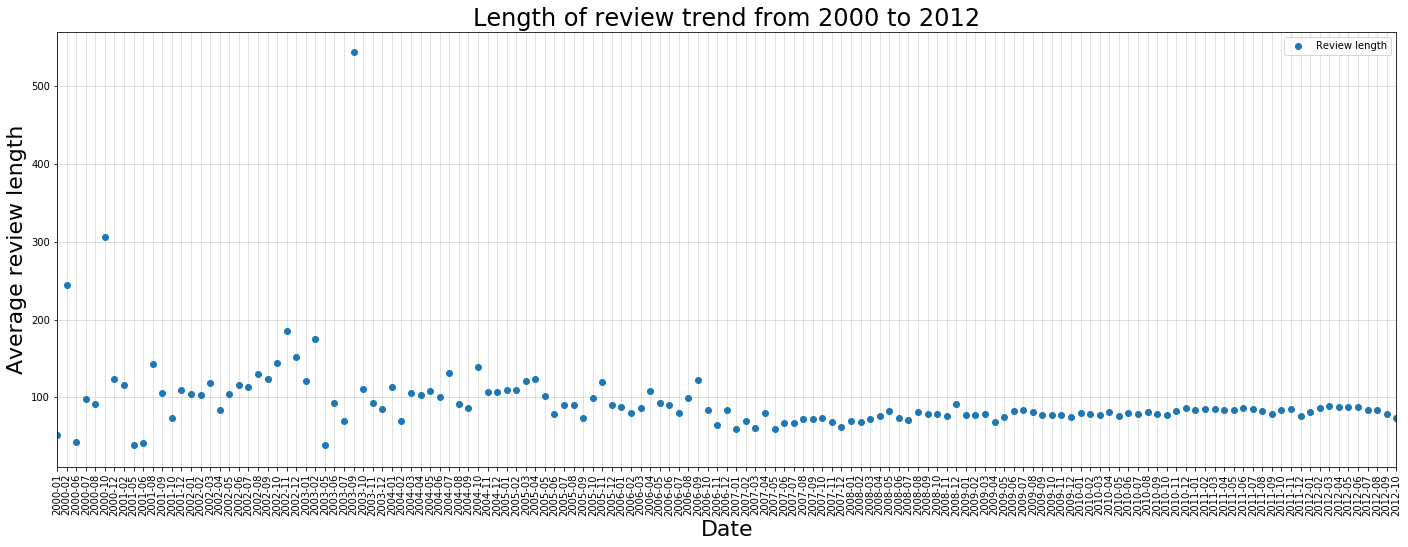

In [63]:
# average review length vs. time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_converted_ym'],y=grp_avg_date['Text_lenght'],label='Review length');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average review length',fontsize=22)
plt.title('Length of review trend from 2000 to 2012',fontsize=24);
plt.savefig('data_review_length_trend.png')
#stable review length

- No special trend is observed, only seems that from 2000 to 2006 due to limited review available there is more standard deviation in the review length statistics

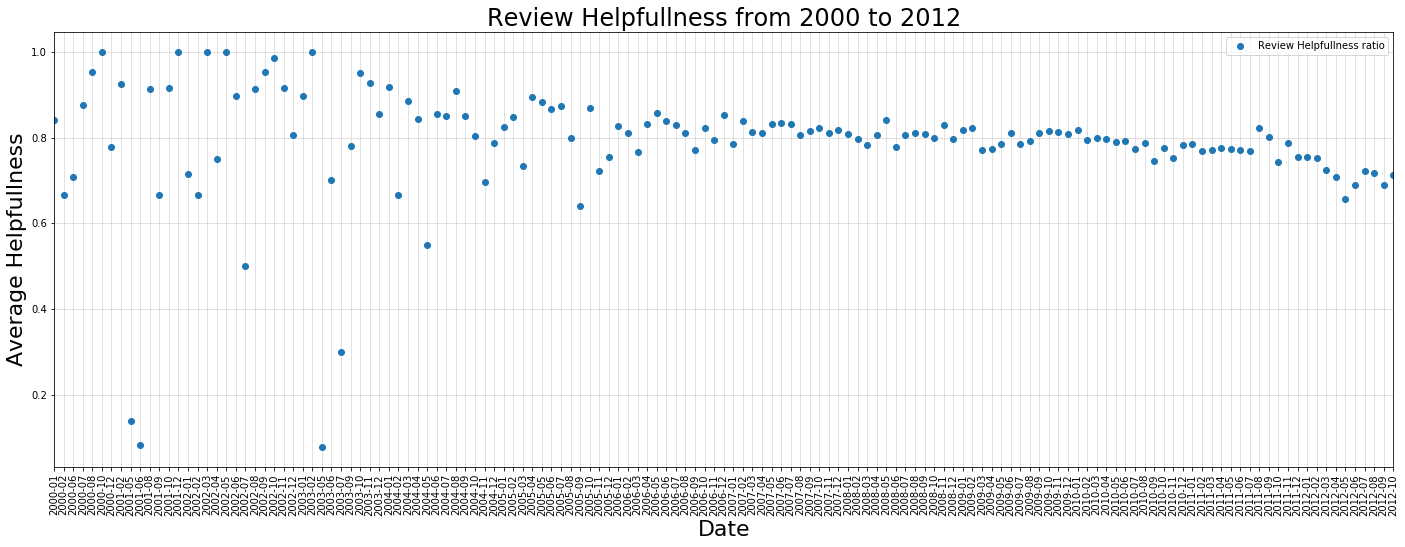

In [64]:
# review helpfulness vs time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_converted_ym'],y=grp_avg_date['Helpfulness_ratio'],label='Review Helpfullness ratio');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average Helpfullness',fontsize=22)
plt.title('Review Helpfullness from 2000 to 2012',fontsize=24);
plt.savefig('data_review_helpful_trend.png')

#drop can be due to visitor not getting time yet to check the reviews of 2012

- No special trend is observed, only seems that later in 2012 slight drop in helpfulness observed, that can be associated with the reciew itself being new and read fewer time

In [65]:
top_reviewer_avg_data.to_csv('top_reviewer_avg_data.csv',index=False)

grp_avg_date.to_csv('grp_avg_date.csv',index=False)

In [66]:
check_name=pd.read_csv('amazon_top_reviewer_list.csv')

## Dataset with fewer columns saved for sentiment analysis

In [67]:
amz_review_less_col=amz_review_sorted_drop_duplicated[['Score','Time_converted_ym', 'Text_new2', 'score_pos_neg']]

In [68]:
amz_review_less_col_rename=amz_review_less_col.rename(columns={'Text_new2':'Review_word_list'})

In [69]:
amz_review_less_col_rename.head()

,Score,Time_converted_ym,Review_word_list,score_pos_neg
0,5,2011-04,"[bought, vitality, canned, dog, food, products...",1
1,1,2012-09,"[product, arrived, labeled, jumbo, salted, pea...",0
2,4,2008-08,"[confection, centuries, light, pillowy, citrus...",1
3,2,2011-06,"[secret, ingredient, robitussin, addition, roo...",0
4,5,2012-10,"[great, taffy, great, price, wide, assortment,...",1


In [70]:
amz_review_less_col_rename.to_csv('amz_review_less_col_rename.csv',index=False)

# Sentiment Analysis

- In this section Machine learning analysis is performed on review text (now in a form of a list) and review score as positive or negative
- The first step is collecting words for all reviews, positive reviews and negative reviews separately in dictionary
- The most common words are checked in each postive and negative group
- Word polarity, which is ratio of a common word occurance in postive review vs, negative review is calculated and words with similar polarity are plotted
- Top 10000 most common words used as our vocabulry. This vocabulry is indexed to vectorized each review
- For each review first 200 words are only considered based on distribution, vectors are padded accordingly
- To account for unbalanced size of review even number of "1" and "0" review (75000) each is used)
- Data is divided into trainig/test set
- Model is trained using deep learning, with one layer of embedding, and two stack of GRU (gated recurrent unit), and one dense layer with sigmoid function

In [71]:
amz_review_less_col_rename=pd.read_csv('amz_review_less_col_rename.csv')
amz_review_less_col_rename['Review_word_list']=amz_review_less_col_rename['Review_word_list'].apply(lambda x: eval(x))

In [72]:
amz_review_less_col_rename.head()

,Score,Time_converted_ym,Review_word_list,score_pos_neg
0,5,2011-04,"[bought, vitality, canned, dog, food, products...",1
1,1,2012-09,"[product, arrived, labeled, jumbo, salted, pea...",0
2,4,2008-08,"[confection, centuries, light, pillowy, citrus...",1
3,2,2011-06,"[secret, ingredient, robitussin, addition, roo...",0
4,5,2012-10,"[great, taffy, great, price, wide, assortment,...",1


## Creating word collector for postive/negative/all reviews

In [73]:
# initialize counters for posiive, negative and all reviews
counter_pos=Counter()
counter_neg=Counter()
counter_total=Counter()

In [74]:
# get individual review, score (0/1) and actual score 1-5 from dataframe in the vector form
review_vec=amz_review_less_col_rename['Review_word_list']
score_vec=amz_review_less_col_rename['score_pos_neg']
actual_score_vec=amz_review_less_col_rename['Score']

## A Negative review 


In [75]:
# very Negative review

for i,review in enumerate(review_vec):
    
    if(i>10 and i<16 and score_vec[i]==0 and actual_score_vec[i]!=3):
        print('Negative',actual_score_vec[i],i,'\n')
        print(review)
        print(' \n')
    
    #print

Negative 1 12 

['cats', 'happily', 'eating', 'felidae', 'platinum', 'years', 'new', 'bag', 'shape', 'food', 'new', 'food', 'bowls', 'bowls', 'sit', 'full', 'kitties', 'will', 'touch', 'food', 'ive', 'noticed', 'similar', 'reviews', 'formula', 'changes', 'unfortunately', 'need', 'find', 'new', 'food', 'cats', 'will', 'eat']
 



## A positive review

In [76]:
for i,review in enumerate(review_vec):
    
    if(i>11 and i<15 and actual_score_vec[i]==5):
        print('Positive',actual_score_vec[i],i,'\n')
        print(review)
        print(' \n')

Positive 5 14 

['strawberry', 'twizzlers', 'guilty', 'pleasure', 'yummy', 'pounds', 'will', 'son']
 



## collection of words are added 

In [77]:
#per postive/negative and total reviews per each review one by one

for i in tqdm(range(len(review_vec))):
    
    try:
        #print(review)
    
        for word in review_vec[i]:        
            counter_total[word] += 1

            if(score_vec[i]==1):
                counter_pos[word] += 1

            if(score_vec[i]==0):
                counter_neg[word] += 1
    except:   
        continue

## Most common words in negative reviews

In [78]:
# top 20 most common words in negative reviews
counter_neg.most_common()[0:20]

[('br', 70376),
 ('like', 68473),
 ('taste', 49301),
 ('product', 45141),
 ('coffee', 38648),
 ('good', 38467),
 ('flavor', 34803),
 ('will', 30477),
 ('food', 27022),
 ('tea', 25483),
 ('buy', 20925),
 ('amazon', 17527),
 ('better', 17436),
 ('again', 17404),
 ('time', 17357),
 ('box', 16800),
 ('dog', 16407),
 ('water', 15809),
 ('great', 15632),
 ('bought', 15343)]

## Most common words in positive reviews

In [79]:
# top 20 most common words in positive reviews
counter_pos.most_common()[0:20]

[('br', 191475),
 ('like', 178215),
 ('good', 153115),
 ('great', 145364),
 ('coffee', 119847),
 ('taste', 114447),
 ('love', 109636),
 ('flavor', 104099),
 ('tea', 104089),
 ('product', 99629),
 ('will', 93568),
 ('food', 89946),
 ('use', 67065),
 ('best', 66555),
 ('time', 62180),
 ('amazon', 59952),
 ('find', 59420),
 ('price', 58940),
 ('ive', 57715),
 ('well', 56124)]

## Creating collector for high polarity words (high pos/neg count)

In [80]:
# This counter only consider words ratio in postive vs negative review,
#if word not in negative collection a "1" is added to avoid NaN
# to avoidvery big or small ratio, a log value is saved

counter_pos_neg=Counter()

#words called in for over 100 times in whole reviews

for word,count in tqdm(counter_total.most_common()):
    if(count>100):
        try: 
            counter_pos_neg[word]=np.log(counter_pos[word]/float(counter_neg[word]+1))
        except:
            continue

## Top most polar words

- Top 40 are most positive polar appear in more postive reviews, bottom 40 polar are most negative, appear more in negative reviews

In [81]:
dict_top_pos=dict(counter_pos_neg.most_common(40))
dict_top_neg=dict(counter_pos_neg.most_common()[:-40:-1])

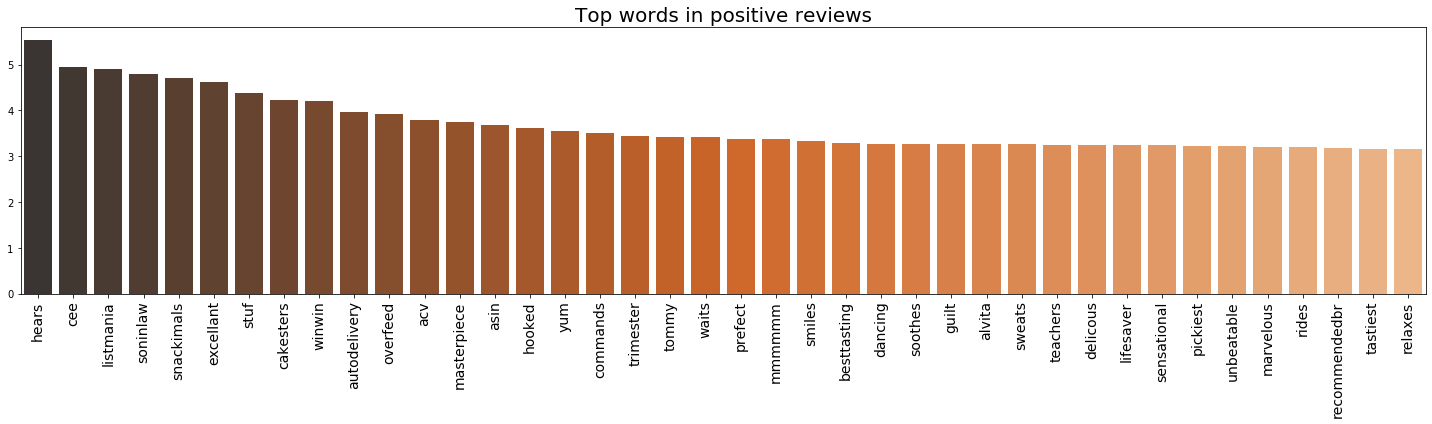

In [82]:
# Top 40 most positive polar


# plt.autolayout : True
# plt.tight_layout();
plt.figure(figsize=(20,6))
sns.barplot(list(dict_top_pos.keys()), list(dict_top_pos.values()), palette="Oranges_d")
plt.xticks(rotation=90,fontsize=14);
plt.title('Top words in positive reviews',fontsize=20);
plt.tight_layout();
plt.savefig('word__freq_pos_rev.png')

The bundle of these polar words very much make sense, with words from "winwin", "mmmmmm", to "smile" and "relax" show postive sentiment

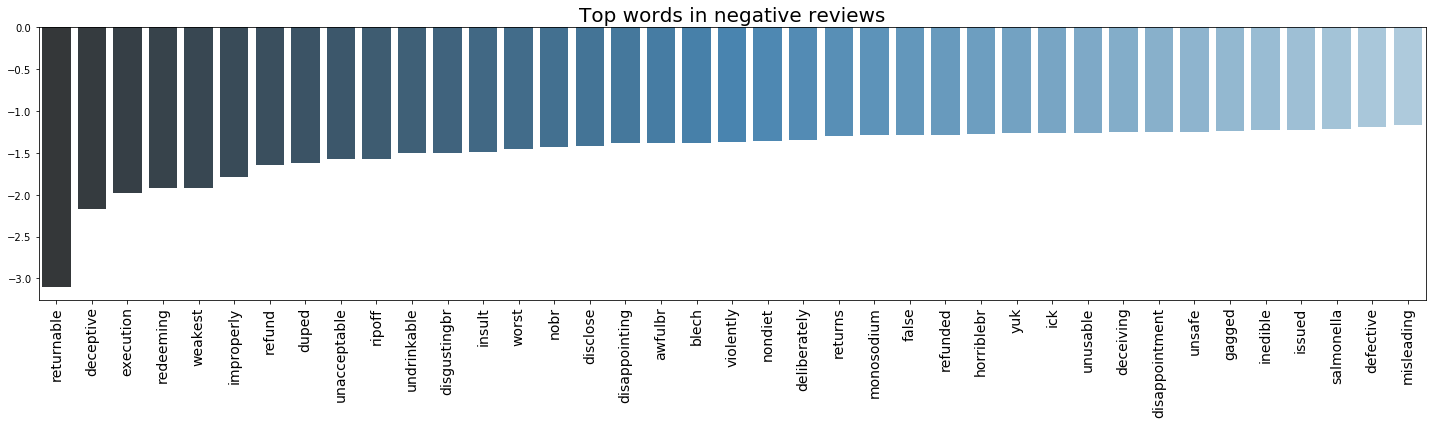

In [83]:
# Top 40 most negative polar

plt.figure(figsize=(20,6))
sns.barplot(list(dict_top_neg.keys()), list(dict_top_neg.values()), palette="Blues_d")
plt.xticks(rotation=90,fontsize=14);
plt.title('Top words in negative reviews',fontsize=20);
plt.tight_layout();
plt.savefig('word__freq_neg_rev.png')

The bundle of these polar words also make sense, with words from "returnable", "deceptive", to "ripoff" and "yuk" show more negative sentiment

Mean: 1.1207146656718978


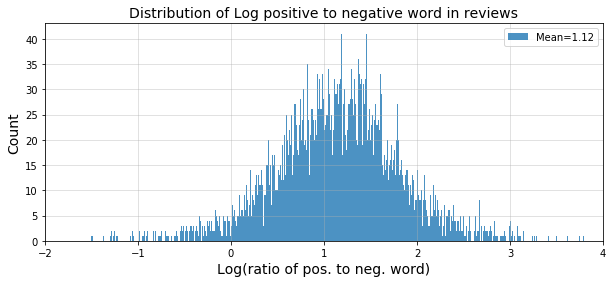

In [84]:
# polarity value distribution
print('Mean:',np.mean(list(set(counter_pos_neg.values()))))
plt.figure(figsize=(10,4));
plt.hist(counter_pos_neg.values(),bins=2000,label='Mean=1.12',alpha=0.8);
plt.xlim(-2,4)

plt.xlabel('Log(ratio of pos. to neg. word)',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Distribution of Log positive to negative word in reviews',fontsize=14)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(loc='upper right');
plt.savefig('distribution_log_pos_neg_word_review.png')

Generally it is expected that polarity values center around one with more Gaussian distribution but due to large number of positive reviews "5' star review the center is actually shifted to 1.12. If in fact this polarity distribution need to be considered for cleaning up dictionary from neutral words (at the peak) which may jot have value to out maching leaninr work, this center shift need to be considered.

In [85]:
#dictionary count in postive, negative, ad total words
print(len(counter_pos_neg.most_common()),len(counter_pos.most_common()),len(counter_neg.most_common()),len(counter_total.most_common()))

9967 186454 92005 223134


In [86]:
print('%0.2f' %counter_pos_neg['neutral'],'%0.2f' %counter_pos_neg['diet'],'%0.2f' %counter_pos_neg['awful'],'%0.2f' %counter_pos_neg['food'])

0.86 1.26 -0.97 1.20


## Using Only top 10000 most common words as dictionary for indexing

In [87]:
# Just use top 10000 common words, these are words that show up at leadt 100 times in reviews
top_10000_common_words_dic=dict(counter_total.most_common()[0:10000])

In [88]:
top_10000_common_words_list=(list(top_10000_common_words_dic.keys()))
print(len(top_10000_common_words_list))

10000


In [89]:
#index the words based on appearance in the most common order, the order of this indexing does not matter,
# just need a rule to convert word to a number, but need to be conssitent through the study though

word_to_index={}
index_to_word={}

for i,word in enumerate(top_10000_common_words_list):
    word_to_index[word]=i
    
for word,i in word_to_index.items():
    index_to_word[i]=word

# {'br': 0, 'like': 1, 'good': 2, 'taste': 3, 'great': 4, 'coffee': 5, 'product': 6, 'flavor': 7, 'tea': 8, 'love': 9, 'will': 10, 'food': 11, 'use': 12
#{0: 'br', 1: 'like', 2: 'good', 3: 'taste', 4: 'great', 5: 'coffee', 6: 'product', 7: 'flavor', 8: 'tea', 9: 'love', 10: 'will', 11: 'food', 12:

## Word index replaces the word string for ML study

In [90]:
# making sure review is not null, and also get corresponding vectors for score, replace the words if they are in
# top 10000 list with their index

review_vec_index=[]
review_label=[]
review_score=[]

for i in tqdm(range(len(review_vec))):
    
    len_rev=len(review_vec[i])
    if(len_rev>0 and len_rev<1750):  #clean very short and very long reviews
        indices = set()
        for word in review_vec[i]:
            if word in word_to_index.keys():
                indices.add(word_to_index[word])
        review_vec_index.append(list(indices))
        review_label.append(score_vec[i])
        review_score.append(actual_score_vec[i])
                
print(len(review_vec_index),len(review_label),len(review_score))               


560380 560380 560380


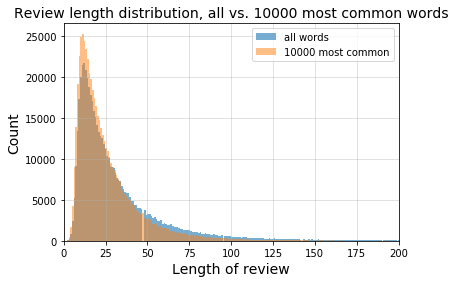

In [91]:
# length of the review before and after considerin only 10000 words
review_len_vec = pd.Series(review_vec).apply(lambda x: len(x)) 
review_len_vec_index = pd.Series(review_vec_index).apply(lambda x: len(x))

review_len_vec.hist(bins=1750,alpha=0.6,label='all words');
review_len_vec_index.hist(bins=589,alpha=0.5,label='10000 most common');
plt.xlim(0,200)
#plt.ylim(0,500)
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlabel('Length of review',fontsize=14);
plt.ylabel('Count',fontsize=14);

plt.title('Review length distribution, all vs. 10000 most common words',fontsize=14);
plt.legend()
plt.savefig('review_length_dist_before_after.png')

In [92]:
# before cosidering null review length 
review_len_vec.describe()

count    560388.000000
mean         32.635103
std          33.231581
min           0.000000
25%          14.000000
50%          23.000000
75%          39.000000
max        1714.000000
Name: Review_word_list, dtype: float64

In [93]:
#after removing null lengths and cosidering only top 10000 words
review_len_vec_index.describe()

count    560380.000000
mean         25.400057
std          20.670301
min           1.000000
25%          12.000000
50%          19.000000
75%          31.000000
max         589.000000
dtype: float64

- After removing the null reviews and considering top 10000 words only distribution shows on average reviews have a length 25, and at 75th percentile up to 30 word. It is safe to day considering a conssitent vector size of 100 for input review is safe and will not lose any informtion

In [94]:
print(pd.Series(review_label).describe())


count    560380.000000
mean          0.780624
std           0.413824
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
dtype: float64


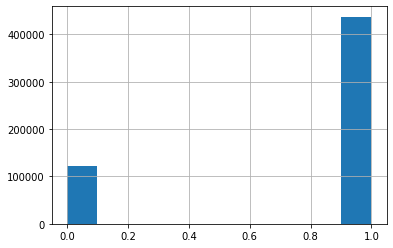

In [95]:
score_vec.hist()

## Example of index vectors

- length of each revire still varies at this stage, but need to be made consistent to 100 word vector as input of out deep learning network

In [96]:

for i,review in enumerate(review_vec_index):
    if(i<3):
        print(i,review_vec_index[i],review_label[i],review_score[i])

0 [352, 1, 2, 8259, 6, 872, 4745, 4842, 11, 77, 2235, 1421, 21, 22, 246, 283, 61, 31] 1 5
1 [1186, 964, 6, 3272, 1802, 1773, 173, 7437, 1649, 2769, 5371, 734, 63] 0 1
2 [9344, 524, 2709, 1942, 28, 1948, 160, 6694, 41, 172, 302, 303, 946, 448, 326, 2125, 80, 1491, 4439, 7384, 7517, 861, 114, 1651, 7413, 5110, 1787, 2174, 383] 1 4


In [97]:
#lists transford into array
review_score=np.array(review_score)
review_vec_index=np.array(review_vec_index)

## Using even number of postive and negative reviews for classification

- Due to uneven nature of "5" star reviews, only even number (75000) postive and negative reviews considerd
- This contain all "1", "2" star review, part of "4" and portio of "5" stars. "3" stars due to it netural content not considered

In [98]:
max_per_pos_neg=75000
counter_pos=0
counter_neg=0
review_vec_index_even=[]
review_label_even=[]
review_score_even=[]

for i in tqdm(range(len(review_score))):
    if((review_score[i]==5 or review_score[i]==4) and counter_pos<max_per_pos_neg):
        
        review_vec_index_even.append(review_vec_index[i])
        review_label_even.append(review_label[i])
        review_score_even.append(review_score[i])
        counter_pos=counter_pos+1
        
    if((review_score[i]==1 or review_score[i]==2) and counter_neg<max_per_pos_neg):
        
        review_vec_index_even.append(review_vec_index[i])
        review_label_even.append(review_label[i])
        review_score_even.append(review_score[i])
        counter_neg=counter_neg+1        
        
        

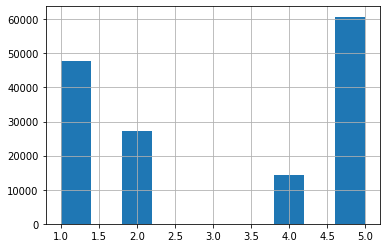

In [99]:
# reviews score after making count of positive and negative even
pd.Series(review_score_even).hist()

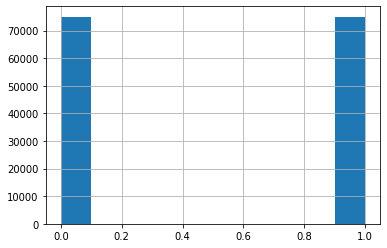

In [100]:
# reviews label after making count of positive and negative even
pd.Series(review_label_even).hist()

## Padding the review index vector to length of 100

- Reviews with less than 100 word get zero at the beginning and ones with more than 100 (very few) cut shor to first 100 words

In [101]:
# padding the review
review_vec_index_pad=sequence.pad_sequences(review_vec_index_even,maxlen=100)
review_label=np.array(review_label_even)

## splitting the data into train and test set

In [102]:
#33% data kept for test, random state fixed for repeatability check
X_train, X_test, y_train, y_test = train_test_split(review_vec_index_pad, review_label, test_size=0.33, random_state=42)

In [103]:
#input data is saved
model_data_input=pd.DataFrame(dict(X_even=review_vec_index_pad.tolist(),y_even=review_label)) #,'y_even':review_label})

In [104]:
model_data_input.to_csv('model_data_input_even.csv',index=False)

In [105]:
model_data_input=pd.read_csv('model_data_input_even.csv')

In [106]:
review_vec_index_pad=model_data_input['X_even'].apply(lambda x: np.asarray(eval(x),dtype='int32')).values
review_label=model_data_input['y_even'].values

## Deep learning: A Supervised learning with Embedding, GRU, and Dense layers and dropout

- Vocabulry size is 10000
- One Embedding layer translate the each index into a vector of size 100
- Input size is 100 words (100 word per review)

### Using Keras 
- The Embedding layer is initialized with random weight and no pre-trained word2vec or GloVe used at this stage. Since the data is large enough to train the embedding layer from scratch.
- Since the final goal of project was understanding the word structures through this training, using a pre-trained model that was frozen in weight would not be appropriate in order to get word relation when it comes to this supervised learning
- The GloVe with 100 and 200 embedding dimension was tested initially but did not impact the accuracy significantly
- Two layers of GRU (gated recurrent unit) used, with Tanh activation, and dropout to avoid over fitting
- Other architecture e.g. LSTM and Conv1D also considered but GRU was ultimatey was chosen for its speed plus accuracy
- A dense layer with 1 output with simoid actuvation is used with binary crossentropy and Adam optimizer

## Model Architecture

In [107]:
# Architecture of the model

max_feature=10000
max_len=100
embedding_dim=100

model=Sequential()
# embedding layer, map eah word index to a dense vector of size 100
model.add(layers.Embedding(max_feature,embedding_dim,input_length=max_len)) 
# First GRU layer, input and output size same (100) , each vetor is 32
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
# Second GRU layer, output size is 1 vector of size 64
model.add(layers.GRU(64,activation='tanh',dropout=0.1,recurrent_dropout=0.5))
# last layer is dense that move 64 size array to 1 with a dense layer and apply sigmoid on top
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

C:\Python\lib\site-packages\keras\layers\recurrent.py:1652: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '
C:\Python\lib\site-packages\keras\layers\recurrent.py:1652: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 32)           12768     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,031,457
Trainable params: 1,031,457
Non-trainable params: 0
_________________________________________________________________


## Compile and fit to the model

In [108]:
# binary cross entropy and Adam optimizer with learning rate 0.001 with accuracy matrics chosen
# model is also saved when validation set (20% of traning data) reaches a minimum in validation loss after each epoch
# batch size is set to 128 review at a time

model.compile(optimizer=Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc'])

callbacks_list=[keras.callbacks.ModelCheckpoint(filepath='my_model_bestrun_gru.h5',save_best_only=True,verbose=1,)]
history=model.fit(X_train,y_train,epochs=5,batch_size=128,validation_split=0.2,callbacks=callbacks_list)

Train on 80400 samples, validate on 20100 samples
Epoch 1/5


25984/80400 [========>.....................] - ETA: 5:33 - loss: 0.6936 - acc: 0.515 - ETA: 5:42 - loss: 0.6930 - acc: 0.535 - ETA: 5:46 - loss: 0.6928 - acc: 0.539 - ETA: 5:47 - loss: 0.6928 - acc: 0.527 - ETA: 5:49 - loss: 0.6926 - acc: 0.526 - ETA: 5:52 - loss: 0.6928 - acc: 0.516 - ETA: 5:52 - loss: 0.6926 - acc: 0.517 - ETA: 5:51 - loss: 0.6921 - acc: 0.519 - ETA: 5:51 - loss: 0.6922 - acc: 0.514 - ETA: 5:50 - loss: 0.6916 - acc: 0.516 - ETA: 5:49 - loss: 0.6913 - acc: 0.517 - ETA: 5:48 - loss: 0.6916 - acc: 0.511 - ETA: 5:46 - loss: 0.6912 - acc: 0.509 - ETA: 5:46 - loss: 0.6908 - acc: 0.511 - ETA: 5:45 - loss: 0.6906 - acc: 0.509 - ETA: 5:45 - loss: 0.6903 - acc: 0.508 - ETA: 5:45 - loss: 0.6899 - acc: 0.511 - ETA: 5:45 - loss: 0.6891 - acc: 0.519 - ETA: 5:44 - loss: 0.6885 - acc: 0.524 - ETA: 5:43 - loss: 0.6875 - acc: 0.535 - ETA: 5:42 - loss: 0.6868 - acc: 0.543 - ETA: 5:41 - loss: 0.6861 - acc: 0.551 - ETA: 5:40 - loss: 0.6847 - acc: 0.561 - ETA: 5:41 - loss: 0.6833 - acc: 0

52096/80400 [==================>...........] - ETA: 4:19 - loss: 0.4009 - acc: 0.810 - ETA: 4:19 - loss: 0.4003 - acc: 0.810 - ETA: 4:18 - loss: 0.3999 - acc: 0.810 - ETA: 4:17 - loss: 0.3995 - acc: 0.811 - ETA: 4:16 - loss: 0.3990 - acc: 0.811 - ETA: 4:16 - loss: 0.3987 - acc: 0.811 - ETA: 4:15 - loss: 0.3987 - acc: 0.811 - ETA: 4:14 - loss: 0.3978 - acc: 0.812 - ETA: 4:14 - loss: 0.3974 - acc: 0.812 - ETA: 4:13 - loss: 0.3971 - acc: 0.812 - ETA: 4:12 - loss: 0.3969 - acc: 0.812 - ETA: 4:12 - loss: 0.3964 - acc: 0.813 - ETA: 4:11 - loss: 0.3959 - acc: 0.813 - ETA: 4:10 - loss: 0.3948 - acc: 0.814 - ETA: 4:10 - loss: 0.3945 - acc: 0.814 - ETA: 4:09 - loss: 0.3940 - acc: 0.814 - ETA: 4:08 - loss: 0.3935 - acc: 0.815 - ETA: 4:08 - loss: 0.3930 - acc: 0.815 - ETA: 4:07 - loss: 0.3928 - acc: 0.815 - ETA: 4:06 - loss: 0.3925 - acc: 0.815 - ETA: 4:06 - loss: 0.3919 - acc: 0.816 - ETA: 4:05 - loss: 0.3917 - acc: 0.816 - ETA: 4:04 - loss: 0.3915 - acc: 0.816 - ETA: 4:03 - loss: 0.3910 - acc: 0

78720/80400 [============================>.] - ETA: 2:13 - loss: 0.3498 - acc: 0.844 - ETA: 2:13 - loss: 0.3498 - acc: 0.844 - ETA: 2:12 - loss: 0.3495 - acc: 0.844 - ETA: 2:12 - loss: 0.3493 - acc: 0.844 - ETA: 2:11 - loss: 0.3491 - acc: 0.844 - ETA: 2:11 - loss: 0.3490 - acc: 0.844 - ETA: 2:10 - loss: 0.3490 - acc: 0.844 - ETA: 2:10 - loss: 0.3487 - acc: 0.845 - ETA: 2:09 - loss: 0.3485 - acc: 0.845 - ETA: 2:08 - loss: 0.3483 - acc: 0.845 - ETA: 2:08 - loss: 0.3480 - acc: 0.845 - ETA: 2:07 - loss: 0.3478 - acc: 0.845 - ETA: 2:07 - loss: 0.3476 - acc: 0.845 - ETA: 2:06 - loss: 0.3475 - acc: 0.845 - ETA: 2:06 - loss: 0.3473 - acc: 0.845 - ETA: 2:05 - loss: 0.3470 - acc: 0.846 - ETA: 2:04 - loss: 0.3471 - acc: 0.845 - ETA: 2:04 - loss: 0.3470 - acc: 0.845 - ETA: 2:03 - loss: 0.3468 - acc: 0.846 - ETA: 2:03 - loss: 0.3466 - acc: 0.846 - ETA: 2:02 - loss: 0.3466 - acc: 0.846 - ETA: 2:01 - loss: 0.3463 - acc: 0.846 - ETA: 2:01 - loss: 0.3461 - acc: 0.846 - ETA: 2:00 - loss: 0.3459 - acc: 0

80400/80400 [==============================] - ETA: 7s - loss: 0.3255 - acc: 0.858 - ETA: 6s - loss: 0.3253 - acc: 0.858 - ETA: 6s - loss: 0.3252 - acc: 0.858 - ETA: 5s - loss: 0.3251 - acc: 0.858 - ETA: 4s - loss: 0.3251 - acc: 0.858 - ETA: 4s - loss: 0.3249 - acc: 0.859 - ETA: 3s - loss: 0.3248 - acc: 0.859 - ETA: 3s - loss: 0.3247 - acc: 0.859 - ETA: 2s - loss: 0.3247 - acc: 0.859 - ETA: 1s - loss: 0.3247 - acc: 0.859 - ETA: 1s - loss: 0.3247 - acc: 0.859 - ETA: 0s - loss: 0.3247 - acc: 0.859 - ETA: 0s - loss: 0.3247 - acc: 0.859 - 410s 5ms/step - loss: 0.3246 - acc: 0.8592 - val_loss: 0.2758 - val_acc: 0.8890

Epoch 00001: val_loss improved from inf to 0.27585, saving model to my_model_bestrun_gru.h5
Epoch 2/5


26112/80400 [========>.....................] - ETA: 5:33 - loss: 0.1893 - acc: 0.937 - ETA: 5:39 - loss: 0.2155 - acc: 0.929 - ETA: 5:44 - loss: 0.2226 - acc: 0.927 - ETA: 5:47 - loss: 0.2370 - acc: 0.918 - ETA: 5:49 - loss: 0.2400 - acc: 0.914 - ETA: 5:55 - loss: 0.2339 - acc: 0.918 - ETA: 5:57 - loss: 0.2281 - acc: 0.920 - ETA: 5:55 - loss: 0.2234 - acc: 0.918 - ETA: 5:56 - loss: 0.2219 - acc: 0.918 - ETA: 5:58 - loss: 0.2196 - acc: 0.918 - ETA: 5:57 - loss: 0.2121 - acc: 0.921 - ETA: 6:03 - loss: 0.2169 - acc: 0.919 - ETA: 6:13 - loss: 0.2134 - acc: 0.920 - ETA: 6:18 - loss: 0.2208 - acc: 0.918 - ETA: 6:22 - loss: 0.2238 - acc: 0.918 - ETA: 6:22 - loss: 0.2225 - acc: 0.917 - ETA: 6:22 - loss: 0.2196 - acc: 0.917 - ETA: 6:20 - loss: 0.2206 - acc: 0.918 - ETA: 6:17 - loss: 0.2190 - acc: 0.918 - ETA: 6:15 - loss: 0.2167 - acc: 0.919 - ETA: 6:12 - loss: 0.2147 - acc: 0.919 - ETA: 6:10 - loss: 0.2182 - acc: 0.918 - ETA: 6:07 - loss: 0.2171 - acc: 0.919 - ETA: 6:05 - loss: 0.2177 - acc: 0

52224/80400 [==================>...........] - ETA: 4:11 - loss: 0.2283 - acc: 0.913 - ETA: 4:10 - loss: 0.2286 - acc: 0.913 - ETA: 4:10 - loss: 0.2284 - acc: 0.913 - ETA: 4:09 - loss: 0.2280 - acc: 0.913 - ETA: 4:08 - loss: 0.2280 - acc: 0.913 - ETA: 4:07 - loss: 0.2281 - acc: 0.913 - ETA: 4:07 - loss: 0.2281 - acc: 0.913 - ETA: 4:06 - loss: 0.2285 - acc: 0.913 - ETA: 4:05 - loss: 0.2284 - acc: 0.913 - ETA: 4:04 - loss: 0.2281 - acc: 0.913 - ETA: 4:04 - loss: 0.2281 - acc: 0.913 - ETA: 4:03 - loss: 0.2281 - acc: 0.913 - ETA: 4:02 - loss: 0.2280 - acc: 0.913 - ETA: 4:02 - loss: 0.2282 - acc: 0.913 - ETA: 4:01 - loss: 0.2281 - acc: 0.913 - ETA: 4:00 - loss: 0.2281 - acc: 0.913 - ETA: 3:59 - loss: 0.2282 - acc: 0.913 - ETA: 3:59 - loss: 0.2281 - acc: 0.913 - ETA: 3:58 - loss: 0.2280 - acc: 0.913 - ETA: 3:58 - loss: 0.2276 - acc: 0.913 - ETA: 3:57 - loss: 0.2277 - acc: 0.913 - ETA: 3:56 - loss: 0.2278 - acc: 0.913 - ETA: 3:55 - loss: 0.2277 - acc: 0.913 - ETA: 3:55 - loss: 0.2279 - acc: 0

78976/80400 [============================>.] - ETA: 2:08 - loss: 0.2347 - acc: 0.909 - ETA: 2:08 - loss: 0.2345 - acc: 0.909 - ETA: 2:07 - loss: 0.2347 - acc: 0.909 - ETA: 2:06 - loss: 0.2345 - acc: 0.909 - ETA: 2:06 - loss: 0.2344 - acc: 0.909 - ETA: 2:05 - loss: 0.2345 - acc: 0.909 - ETA: 2:05 - loss: 0.2344 - acc: 0.909 - ETA: 2:04 - loss: 0.2342 - acc: 0.909 - ETA: 2:03 - loss: 0.2341 - acc: 0.910 - ETA: 2:03 - loss: 0.2342 - acc: 0.910 - ETA: 2:02 - loss: 0.2344 - acc: 0.909 - ETA: 2:01 - loss: 0.2342 - acc: 0.910 - ETA: 2:01 - loss: 0.2344 - acc: 0.909 - ETA: 2:00 - loss: 0.2345 - acc: 0.909 - ETA: 2:00 - loss: 0.2345 - acc: 0.910 - ETA: 1:59 - loss: 0.2342 - acc: 0.910 - ETA: 1:59 - loss: 0.2342 - acc: 0.910 - ETA: 1:58 - loss: 0.2342 - acc: 0.910 - ETA: 1:58 - loss: 0.2342 - acc: 0.910 - ETA: 1:57 - loss: 0.2342 - acc: 0.910 - ETA: 1:56 - loss: 0.2344 - acc: 0.910 - ETA: 1:56 - loss: 0.2343 - acc: 0.910 - ETA: 1:55 - loss: 0.2345 - acc: 0.910 - ETA: 1:55 - loss: 0.2344 - acc: 0

80400/80400 [==============================] - ETA: 5s - loss: 0.2372 - acc: 0.908 - ETA: 5s - loss: 0.2371 - acc: 0.908 - ETA: 4s - loss: 0.2372 - acc: 0.908 - ETA: 4s - loss: 0.2372 - acc: 0.908 - ETA: 3s - loss: 0.2371 - acc: 0.908 - ETA: 2s - loss: 0.2370 - acc: 0.908 - ETA: 2s - loss: 0.2371 - acc: 0.908 - ETA: 1s - loss: 0.2372 - acc: 0.908 - ETA: 1s - loss: 0.2371 - acc: 0.908 - ETA: 0s - loss: 0.2372 - acc: 0.908 - ETA: 0s - loss: 0.2371 - acc: 0.908 - 393s 5ms/step - loss: 0.2371 - acc: 0.9081 - val_loss: 0.2715 - val_acc: 0.8929

Epoch 00002: val_loss improved from 0.27585 to 0.27153, saving model to my_model_bestrun_gru.h5
Epoch 3/5


26112/80400 [========>.....................] - ETA: 5:31 - loss: 0.2307 - acc: 0.898 - ETA: 5:27 - loss: 0.2215 - acc: 0.910 - ETA: 5:23 - loss: 0.1972 - acc: 0.919 - ETA: 5:25 - loss: 0.1883 - acc: 0.919 - ETA: 5:29 - loss: 0.1795 - acc: 0.925 - ETA: 5:28 - loss: 0.1769 - acc: 0.928 - ETA: 5:31 - loss: 0.1817 - acc: 0.930 - ETA: 5:31 - loss: 0.1881 - acc: 0.927 - ETA: 5:31 - loss: 0.1939 - acc: 0.926 - ETA: 5:30 - loss: 0.1897 - acc: 0.926 - ETA: 5:29 - loss: 0.1930 - acc: 0.923 - ETA: 5:27 - loss: 0.2005 - acc: 0.921 - ETA: 5:26 - loss: 0.1961 - acc: 0.923 - ETA: 5:27 - loss: 0.1996 - acc: 0.922 - ETA: 5:29 - loss: 0.1982 - acc: 0.922 - ETA: 5:29 - loss: 0.1938 - acc: 0.924 - ETA: 5:29 - loss: 0.1867 - acc: 0.927 - ETA: 5:28 - loss: 0.1879 - acc: 0.927 - ETA: 5:28 - loss: 0.1844 - acc: 0.929 - ETA: 5:26 - loss: 0.1838 - acc: 0.930 - ETA: 5:25 - loss: 0.1836 - acc: 0.930 - ETA: 5:24 - loss: 0.1838 - acc: 0.930 - ETA: 5:23 - loss: 0.1811 - acc: 0.931 - ETA: 5:22 - loss: 0.1796 - acc: 0

52224/80400 [==================>...........] - ETA: 4:05 - loss: 0.1880 - acc: 0.929 - ETA: 4:05 - loss: 0.1881 - acc: 0.929 - ETA: 4:04 - loss: 0.1883 - acc: 0.929 - ETA: 4:04 - loss: 0.1890 - acc: 0.929 - ETA: 4:03 - loss: 0.1893 - acc: 0.929 - ETA: 4:02 - loss: 0.1890 - acc: 0.929 - ETA: 4:02 - loss: 0.1887 - acc: 0.929 - ETA: 4:01 - loss: 0.1885 - acc: 0.929 - ETA: 4:00 - loss: 0.1887 - acc: 0.929 - ETA: 4:00 - loss: 0.1891 - acc: 0.929 - ETA: 3:59 - loss: 0.1889 - acc: 0.929 - ETA: 3:58 - loss: 0.1886 - acc: 0.929 - ETA: 3:58 - loss: 0.1886 - acc: 0.929 - ETA: 3:57 - loss: 0.1885 - acc: 0.929 - ETA: 3:56 - loss: 0.1890 - acc: 0.929 - ETA: 3:56 - loss: 0.1897 - acc: 0.929 - ETA: 3:55 - loss: 0.1899 - acc: 0.929 - ETA: 3:55 - loss: 0.1898 - acc: 0.929 - ETA: 3:54 - loss: 0.1899 - acc: 0.929 - ETA: 3:53 - loss: 0.1904 - acc: 0.928 - ETA: 3:53 - loss: 0.1904 - acc: 0.928 - ETA: 3:52 - loss: 0.1903 - acc: 0.928 - ETA: 3:51 - loss: 0.1904 - acc: 0.928 - ETA: 3:51 - loss: 0.1904 - acc: 0

78976/80400 [============================>.] - ETA: 2:07 - loss: 0.1962 - acc: 0.926 - ETA: 2:07 - loss: 0.1963 - acc: 0.926 - ETA: 2:06 - loss: 0.1962 - acc: 0.926 - ETA: 2:05 - loss: 0.1962 - acc: 0.926 - ETA: 2:05 - loss: 0.1961 - acc: 0.926 - ETA: 2:04 - loss: 0.1960 - acc: 0.926 - ETA: 2:03 - loss: 0.1960 - acc: 0.926 - ETA: 2:03 - loss: 0.1961 - acc: 0.926 - ETA: 2:02 - loss: 0.1962 - acc: 0.926 - ETA: 2:02 - loss: 0.1962 - acc: 0.926 - ETA: 2:01 - loss: 0.1961 - acc: 0.926 - ETA: 2:00 - loss: 0.1963 - acc: 0.926 - ETA: 2:00 - loss: 0.1963 - acc: 0.926 - ETA: 1:59 - loss: 0.1963 - acc: 0.926 - ETA: 1:59 - loss: 0.1963 - acc: 0.926 - ETA: 1:58 - loss: 0.1962 - acc: 0.926 - ETA: 1:57 - loss: 0.1963 - acc: 0.925 - ETA: 1:57 - loss: 0.1966 - acc: 0.925 - ETA: 1:56 - loss: 0.1965 - acc: 0.925 - ETA: 1:55 - loss: 0.1964 - acc: 0.926 - ETA: 1:55 - loss: 0.1964 - acc: 0.926 - ETA: 1:54 - loss: 0.1964 - acc: 0.926 - ETA: 1:54 - loss: 0.1963 - acc: 0.926 - ETA: 1:53 - loss: 0.1963 - acc: 0

80400/80400 [==============================] - ETA: 5s - loss: 0.2014 - acc: 0.923 - ETA: 5s - loss: 0.2013 - acc: 0.923 - ETA: 4s - loss: 0.2014 - acc: 0.923 - ETA: 4s - loss: 0.2013 - acc: 0.923 - ETA: 3s - loss: 0.2015 - acc: 0.923 - ETA: 2s - loss: 0.2016 - acc: 0.923 - ETA: 2s - loss: 0.2016 - acc: 0.923 - ETA: 1s - loss: 0.2017 - acc: 0.923 - ETA: 1s - loss: 0.2018 - acc: 0.923 - ETA: 0s - loss: 0.2017 - acc: 0.923 - ETA: 0s - loss: 0.2018 - acc: 0.923 - 385s 5ms/step - loss: 0.2018 - acc: 0.9235 - val_loss: 0.2807 - val_acc: 0.8922

Epoch 00003: val_loss did not improve from 0.27153
Epoch 4/5


26112/80400 [========>.....................] - ETA: 5:18 - loss: 0.2346 - acc: 0.921 - ETA: 5:14 - loss: 0.2044 - acc: 0.933 - ETA: 5:14 - loss: 0.1950 - acc: 0.932 - ETA: 5:13 - loss: 0.1849 - acc: 0.933 - ETA: 5:08 - loss: 0.1827 - acc: 0.934 - ETA: 5:10 - loss: 0.1745 - acc: 0.941 - ETA: 5:09 - loss: 0.1812 - acc: 0.939 - ETA: 5:07 - loss: 0.1794 - acc: 0.941 - ETA: 5:08 - loss: 0.1732 - acc: 0.944 - ETA: 5:12 - loss: 0.1681 - acc: 0.946 - ETA: 5:13 - loss: 0.1703 - acc: 0.943 - ETA: 5:11 - loss: 0.1690 - acc: 0.942 - ETA: 5:15 - loss: 0.1684 - acc: 0.940 - ETA: 5:17 - loss: 0.1706 - acc: 0.938 - ETA: 5:25 - loss: 0.1714 - acc: 0.938 - ETA: 5:31 - loss: 0.1695 - acc: 0.939 - ETA: 5:38 - loss: 0.1650 - acc: 0.942 - ETA: 5:42 - loss: 0.1650 - acc: 0.943 - ETA: 5:45 - loss: 0.1623 - acc: 0.944 - ETA: 5:44 - loss: 0.1604 - acc: 0.945 - ETA: 5:44 - loss: 0.1599 - acc: 0.945 - ETA: 5:47 - loss: 0.1595 - acc: 0.945 - ETA: 5:50 - loss: 0.1604 - acc: 0.943 - ETA: 5:52 - loss: 0.1598 - acc: 0

52224/80400 [==================>...........] - ETA: 4:08 - loss: 0.1594 - acc: 0.942 - ETA: 4:07 - loss: 0.1590 - acc: 0.942 - ETA: 4:07 - loss: 0.1594 - acc: 0.942 - ETA: 4:06 - loss: 0.1595 - acc: 0.942 - ETA: 4:05 - loss: 0.1594 - acc: 0.942 - ETA: 4:05 - loss: 0.1598 - acc: 0.942 - ETA: 4:04 - loss: 0.1601 - acc: 0.941 - ETA: 4:04 - loss: 0.1603 - acc: 0.941 - ETA: 4:03 - loss: 0.1602 - acc: 0.941 - ETA: 4:02 - loss: 0.1601 - acc: 0.941 - ETA: 4:02 - loss: 0.1604 - acc: 0.941 - ETA: 4:01 - loss: 0.1605 - acc: 0.941 - ETA: 4:00 - loss: 0.1605 - acc: 0.941 - ETA: 3:59 - loss: 0.1602 - acc: 0.941 - ETA: 3:59 - loss: 0.1601 - acc: 0.941 - ETA: 3:58 - loss: 0.1602 - acc: 0.941 - ETA: 3:57 - loss: 0.1600 - acc: 0.941 - ETA: 3:57 - loss: 0.1607 - acc: 0.941 - ETA: 3:56 - loss: 0.1606 - acc: 0.941 - ETA: 3:55 - loss: 0.1608 - acc: 0.941 - ETA: 3:54 - loss: 0.1610 - acc: 0.941 - ETA: 3:54 - loss: 0.1610 - acc: 0.941 - ETA: 3:53 - loss: 0.1613 - acc: 0.941 - ETA: 3:53 - loss: 0.1613 - acc: 0

78976/80400 [============================>.] - ETA: 2:00 - loss: 0.1681 - acc: 0.938 - ETA: 1:59 - loss: 0.1681 - acc: 0.938 - ETA: 1:59 - loss: 0.1681 - acc: 0.938 - ETA: 1:58 - loss: 0.1682 - acc: 0.938 - ETA: 1:57 - loss: 0.1682 - acc: 0.938 - ETA: 1:57 - loss: 0.1682 - acc: 0.938 - ETA: 1:56 - loss: 0.1681 - acc: 0.938 - ETA: 1:56 - loss: 0.1683 - acc: 0.938 - ETA: 1:55 - loss: 0.1682 - acc: 0.938 - ETA: 1:55 - loss: 0.1681 - acc: 0.938 - ETA: 1:54 - loss: 0.1680 - acc: 0.938 - ETA: 1:54 - loss: 0.1680 - acc: 0.938 - ETA: 1:53 - loss: 0.1679 - acc: 0.938 - ETA: 1:53 - loss: 0.1680 - acc: 0.938 - ETA: 1:52 - loss: 0.1682 - acc: 0.938 - ETA: 1:52 - loss: 0.1682 - acc: 0.938 - ETA: 1:51 - loss: 0.1683 - acc: 0.938 - ETA: 1:51 - loss: 0.1683 - acc: 0.938 - ETA: 1:50 - loss: 0.1684 - acc: 0.938 - ETA: 1:50 - loss: 0.1685 - acc: 0.938 - ETA: 1:49 - loss: 0.1684 - acc: 0.938 - ETA: 1:49 - loss: 0.1685 - acc: 0.938 - ETA: 1:48 - loss: 0.1685 - acc: 0.938 - ETA: 1:48 - loss: 0.1685 - acc: 0

80400/80400 [==============================] - ETA: 5s - loss: 0.1743 - acc: 0.935 - ETA: 5s - loss: 0.1743 - acc: 0.935 - ETA: 4s - loss: 0.1741 - acc: 0.935 - ETA: 3s - loss: 0.1742 - acc: 0.935 - ETA: 3s - loss: 0.1742 - acc: 0.935 - ETA: 2s - loss: 0.1741 - acc: 0.935 - ETA: 2s - loss: 0.1741 - acc: 0.935 - ETA: 1s - loss: 0.1741 - acc: 0.935 - ETA: 1s - loss: 0.1740 - acc: 0.935 - ETA: 0s - loss: 0.1741 - acc: 0.935 - ETA: 0s - loss: 0.1741 - acc: 0.935 - 378s 5ms/step - loss: 0.1741 - acc: 0.9356 - val_loss: 0.2939 - val_acc: 0.8917

Epoch 00004: val_loss did not improve from 0.27153
Epoch 5/5


26112/80400 [========>.....................] - ETA: 6:23 - loss: 0.1226 - acc: 0.960 - ETA: 6:19 - loss: 0.1167 - acc: 0.968 - ETA: 6:22 - loss: 0.1283 - acc: 0.963 - ETA: 6:35 - loss: 0.1249 - acc: 0.966 - ETA: 6:42 - loss: 0.1259 - acc: 0.967 - ETA: 6:35 - loss: 0.1304 - acc: 0.964 - ETA: 6:25 - loss: 0.1399 - acc: 0.959 - ETA: 6:18 - loss: 0.1411 - acc: 0.959 - ETA: 6:11 - loss: 0.1388 - acc: 0.958 - ETA: 6:05 - loss: 0.1369 - acc: 0.957 - ETA: 6:10 - loss: 0.1319 - acc: 0.958 - ETA: 6:14 - loss: 0.1284 - acc: 0.960 - ETA: 6:13 - loss: 0.1283 - acc: 0.959 - ETA: 6:15 - loss: 0.1254 - acc: 0.959 - ETA: 6:16 - loss: 0.1234 - acc: 0.959 - ETA: 6:16 - loss: 0.1247 - acc: 0.958 - ETA: 6:16 - loss: 0.1300 - acc: 0.956 - ETA: 6:15 - loss: 0.1307 - acc: 0.955 - ETA: 6:12 - loss: 0.1314 - acc: 0.955 - ETA: 6:09 - loss: 0.1316 - acc: 0.955 - ETA: 6:06 - loss: 0.1306 - acc: 0.956 - ETA: 6:03 - loss: 0.1324 - acc: 0.956 - ETA: 6:00 - loss: 0.1340 - acc: 0.955 - ETA: 5:57 - loss: 0.1336 - acc: 0

52224/80400 [==================>...........] - ETA: 3:56 - loss: 0.1340 - acc: 0.952 - ETA: 3:55 - loss: 0.1342 - acc: 0.952 - ETA: 3:54 - loss: 0.1340 - acc: 0.952 - ETA: 3:54 - loss: 0.1341 - acc: 0.952 - ETA: 3:53 - loss: 0.1343 - acc: 0.952 - ETA: 3:53 - loss: 0.1341 - acc: 0.952 - ETA: 3:52 - loss: 0.1340 - acc: 0.952 - ETA: 3:51 - loss: 0.1338 - acc: 0.952 - ETA: 3:51 - loss: 0.1337 - acc: 0.952 - ETA: 3:51 - loss: 0.1336 - acc: 0.952 - ETA: 3:50 - loss: 0.1336 - acc: 0.952 - ETA: 3:49 - loss: 0.1337 - acc: 0.952 - ETA: 3:49 - loss: 0.1337 - acc: 0.952 - ETA: 3:49 - loss: 0.1339 - acc: 0.952 - ETA: 3:48 - loss: 0.1336 - acc: 0.952 - ETA: 3:48 - loss: 0.1338 - acc: 0.952 - ETA: 3:47 - loss: 0.1339 - acc: 0.952 - ETA: 3:47 - loss: 0.1341 - acc: 0.952 - ETA: 3:46 - loss: 0.1340 - acc: 0.952 - ETA: 3:45 - loss: 0.1337 - acc: 0.952 - ETA: 3:45 - loss: 0.1337 - acc: 0.952 - ETA: 3:44 - loss: 0.1337 - acc: 0.952 - ETA: 3:44 - loss: 0.1339 - acc: 0.952 - ETA: 3:44 - loss: 0.1340 - acc: 0

78976/80400 [============================>.] - ETA: 2:01 - loss: 0.1426 - acc: 0.948 - ETA: 2:01 - loss: 0.1427 - acc: 0.948 - ETA: 2:00 - loss: 0.1426 - acc: 0.948 - ETA: 2:00 - loss: 0.1426 - acc: 0.948 - ETA: 1:59 - loss: 0.1428 - acc: 0.948 - ETA: 1:58 - loss: 0.1428 - acc: 0.948 - ETA: 1:58 - loss: 0.1428 - acc: 0.948 - ETA: 1:57 - loss: 0.1428 - acc: 0.948 - ETA: 1:57 - loss: 0.1427 - acc: 0.948 - ETA: 1:56 - loss: 0.1426 - acc: 0.948 - ETA: 1:56 - loss: 0.1427 - acc: 0.948 - ETA: 1:55 - loss: 0.1427 - acc: 0.948 - ETA: 1:55 - loss: 0.1427 - acc: 0.948 - ETA: 1:54 - loss: 0.1429 - acc: 0.948 - ETA: 1:53 - loss: 0.1430 - acc: 0.948 - ETA: 1:53 - loss: 0.1431 - acc: 0.948 - ETA: 1:52 - loss: 0.1431 - acc: 0.948 - ETA: 1:52 - loss: 0.1430 - acc: 0.948 - ETA: 1:51 - loss: 0.1429 - acc: 0.948 - ETA: 1:51 - loss: 0.1429 - acc: 0.948 - ETA: 1:50 - loss: 0.1429 - acc: 0.948 - ETA: 1:50 - loss: 0.1429 - acc: 0.948 - ETA: 1:49 - loss: 0.1430 - acc: 0.948 - ETA: 1:48 - loss: 0.1430 - acc: 0

80400/80400 [==============================] - ETA: 5s - loss: 0.1498 - acc: 0.945 - ETA: 4s - loss: 0.1499 - acc: 0.945 - ETA: 4s - loss: 0.1501 - acc: 0.945 - ETA: 3s - loss: 0.1501 - acc: 0.945 - ETA: 3s - loss: 0.1502 - acc: 0.945 - ETA: 2s - loss: 0.1502 - acc: 0.945 - ETA: 2s - loss: 0.1501 - acc: 0.945 - ETA: 1s - loss: 0.1502 - acc: 0.945 - ETA: 1s - loss: 0.1503 - acc: 0.945 - ETA: 0s - loss: 0.1505 - acc: 0.945 - ETA: 0s - loss: 0.1505 - acc: 0.945 - 371s 5ms/step - loss: 0.1505 - acc: 0.9452 - val_loss: 0.3101 - val_acc: 0.8888

Epoch 00005: val_loss did not improve from 0.27153


model shows slight overfitting later in the run but middle of run results (epoch 2 ) will be used only for furture analysis

In [109]:
# final model saved
model.save('my_model_endrun_gru.h5')
model_endrun_gru = keras.models.load_model('my_model_endrun_gru.h5')

# accuracy on test data
model_endrun_gru.evaluate(X_test,y_test)

28128/49500 [================>.............] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

49500/49500 [==============================] - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA

[0.3135354598977349, 0.8864848613739014]

In [110]:
# best model saved (minimum validation loss)
model_bestrun_gru = keras.models.load_model('my_model_bestrun_gru.h5')

In [111]:
model_bestrun_gru.evaluate(X_test,y_test)

26080/49500 [==============>...............] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

49500/49500 [==============================] - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA

[0.2738815030425486, 0.8896363377571106]

A good 0.89 accuracy is acheived, This model will be used for further analysis

## Run history vs. epoch

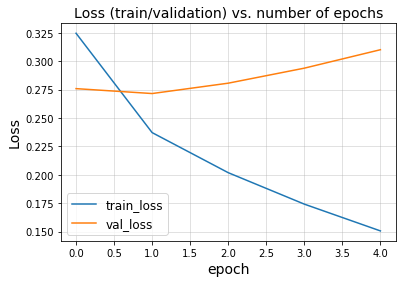

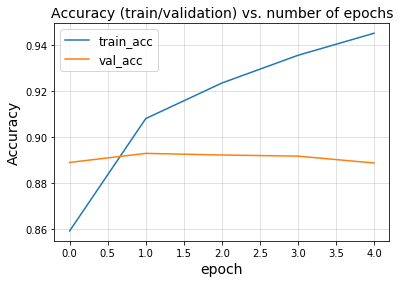

In [112]:
# run history for Train and validation set, Accuracy and Loss

list_epoch=np.arange(0,5)
plt.plot(list_epoch,history.history['loss'])
plt.plot(list_epoch,history.history['val_loss'])
plt.ylabel('Loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(['train_loss','val_loss'],fontsize=12)
plt.title('Loss (train/validation) vs. number of epochs',fontsize=14)
plt.savefig('loss_epoch.png')
plt.show()


plt.plot(list_epoch,history.history['acc'])
plt.plot(list_epoch,history.history['val_acc'])
plt.ylabel('Accuracy',fontsize=14)
plt.legend(['train_acc','val_acc'],fontsize=12)
plt.grid(linewidth=0.5,alpha=0.75)
plt.title('Accuracy (train/validation) vs. number of epochs',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.savefig('accuracy_epoch.png')
plt.show()

- After the first iteration the validation loss does not improve any more while the training accuracy keep improving.
- This indicate overfitting the model, despite using moderate dropout. However, data for validation at epoch=2 is used later analysis
- The best validation accuracy reaches 0.89, which is good for this problem
- The test and validation accuracy stays consistent around 0.89

In [113]:
# Getting the weights of the embedding layer for further analysis on word structures
embedding_matrix=model_bestrun_gru.layers[0].get_weights()[0]

In [114]:
#Saving prediction for test data 
prediction=model_bestrun_gru.predict(X_test)

In [115]:
#saving probability for test data, used for AUC
prediction_proba=model_bestrun_gru.predict_proba(X_test)

In [116]:
# rounding the test prediction 
prediction_round=np.round(prediction)
y_test_vec=y_test.reshape(y_test.shape[0],1)

## Test Accuracy, confusion matrix, F1 score and AUC

In [117]:
# Test accuracy
print('Accuracy:',(y_test_vec==prediction_round).mean())

Accuracy: 0.8896363636363637


In [118]:
from sklearn.metrics import f1_score,accuracy_score,auc,confusion_matrix,roc_curve,roc_auc_score

In [119]:
# Test metrics, accuracy, confusion matrix and F1 score

print('Accuracy: \n \n%0.2f'%accuracy_score(y_test_vec, prediction_round))
print('\nconfusion matrix: \n \n',confusion_matrix(y_test_vec, prediction_round))
print('\nF1 score: \n \n%0.2f' % f1_score(y_test_vec, prediction_round))      

Accuracy: 
 
0.89

confusion matrix: 
 
 [[22635  2186]
 [ 3277 21402]]

F1 score: 
 
0.89


- Accuracy and F1 score show around 0.89 consistent, also True positive and True negative are very similar in confusion matrix. 
- Around 5000 FN and FP are present and mis-categorized

In [120]:
# reshaping the vector for AUC
y_test_vec_n=y_test_vec.reshape(49500)
prediction_proba_n=prediction_proba.reshape(49500)

In [121]:
prediction_proba_n[:]

array([0.9723611 , 0.9722534 , 0.8239221 , ..., 0.0119354 , 0.00809659,
       0.9863062 ], dtype=float32)

In [122]:
#confusion matrix is saved

cm=confusion_matrix(y_test_vec, prediction_round)

In [123]:
# Plotting confusio matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Input:
    
    Confusion matrix
    
    
    Output:
    
    confusion matrix color plot
    
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

## Confusion matrix

Confusion matrix
[[22635  2186]
 [ 3277 21402]]


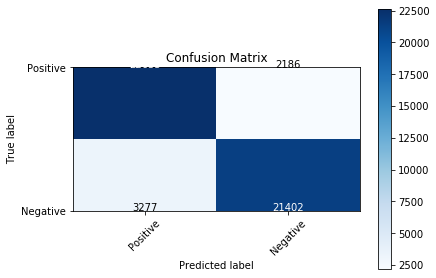

In [124]:
cm_plot_labels = ['Positive','Negative']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## ROC curve

In [125]:
# Calculating ROC curve

n_classes=1

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(np.array(y_test_vec_n), np.array(prediction_proba_n))
    #print(fpr)
    #print(tpr)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC %0.2f '% roc_auc)



ROC_AUC 0.96 


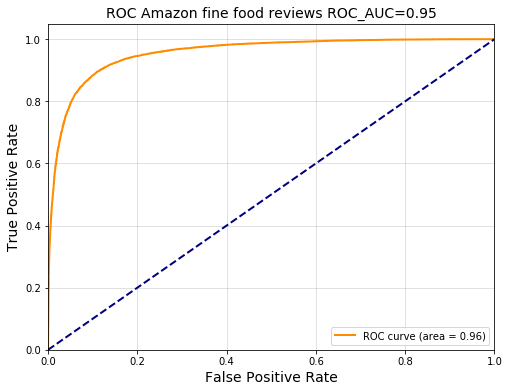

In [126]:
#Plotting ROC curve, Flase positve vs. True positive with prediction probability

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC Amazon fine food reviews ROC_AUC=0.95',fontsize=14)
plt.legend(loc="lower right")
plt.grid(linewidth=0.5,alpha=0.75)
plt.savefig('roc_auc.png')
plt.show()

## Using calculated word Embedding matrix for word structure analysis

In [127]:
# create a word dictionary that connect to words to its dense embedding vector, that saved from output of the model
max_feature=10000

embedding_coeff_dict={}

for word,index in word_to_index.items():  #from imdb vocabulary
    
    if((index<max_feature) and (embedding_matrix[index] is not None)):
        
        embedding_coeff_dict[word]=embedding_matrix[index]  #coeff to dictionary


## Calculating word closeness using cosine similarity

- The higher and closer to one is the cosine similarity, the closer words are together and positively correlated
- The high but negative cosine shows words are negatively correlated
- Closer to zero values show orthogonl relation, no correlation

In [128]:
# Using cosine of the vector get close cosine (or dot product)

def most_similar_words(focus):   
    most_similar = Counter()

    for word in word_to_index.keys():
        most_similar[word] = np.dot(embedding_coeff_dict[word],embedding_coeff_dict[focus])
        #vector weights on hidden layer dot product, higher cosine more simialr vector
    return most_similar.most_common()

In [129]:
most_similar_words("awful") [0:10]

[('disappointing', 1.9454031),
 ('unacceptable', 1.8627973),
 ('worst', 1.8605797),
 ('awful', 1.8252956),
 ('disappointment', 1.7907681),
 ('returning', 1.6459434),
 ('returnable', 1.6423718),
 ('essentia', 1.6333008),
 ('worsebr', 1.5591927),
 ('blech', 1.551091)]

- Top words with similar correlation with "awful" make sense

In [130]:
most_similar_words("excellent") [0:10]

[('hooked', 1.2554443),
 ('pleasantly', 1.2435045),
 ('downside', 1.100936),
 ('drawback', 1.0582461),
 ('excellent', 1.049751),
 ('delicious', 1.0113845),
 ('addicted', 0.95835316),
 ('classy', 0.9148505),
 ('awsome', 0.914145),
 ('deliciousness', 0.9085666)]

- Top words with similar correlation with "excellent" make sense

In [131]:
np.dot(embedding_coeff_dict['excellent'],embedding_coeff_dict['great'])

0.64531744

In [132]:
np.dot(embedding_coeff_dict['excellent'],embedding_coeff_dict['awful'])

-1.0207924

Example of negatively correlated words

In [133]:
np.dot(embedding_coeff_dict['dog'],embedding_coeff_dict['cat'])

-0.03626665

Example of neutral words

## Words structure visualization using T-SNE (Unsupervised approach)

- Consider top 500 polar words
- Assign 2 color map for positive and negative reviews to the word
- Instansiate the t-SNE with two dimesnion

In [134]:
# consider top 500 polar words

import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in counter_pos_neg.most_common(500):
    if(word in embedding_coeff_dict.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(counter_pos_neg.most_common()))[0:500]:
    if(word in embedding_coeff_dict.keys()):
        words_to_visualize.append(word)

In [135]:
# assign a color map to positive and negative reviews

pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in counter_pos_neg.keys():
        vectors_list.append(embedding_coeff_dict[word])
        # put maybe beyond 1.12 better for center shift, but since is only 
        # 500 words should be ok
        if(counter_pos_neg[word] > 0):
            pos+=1
            colors_list.append("#ffc300")
        else:
            neg+=1
            colors_list.append("#0090ff")

## Fit t-SNE in two dimension

In [136]:
# instantiate the t-SNE from sckit in two dimension, with embedding vector as input

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [137]:
# plotting t-SNE
import bokeh
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=7, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="10pt", text_color="#7f7f84",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)

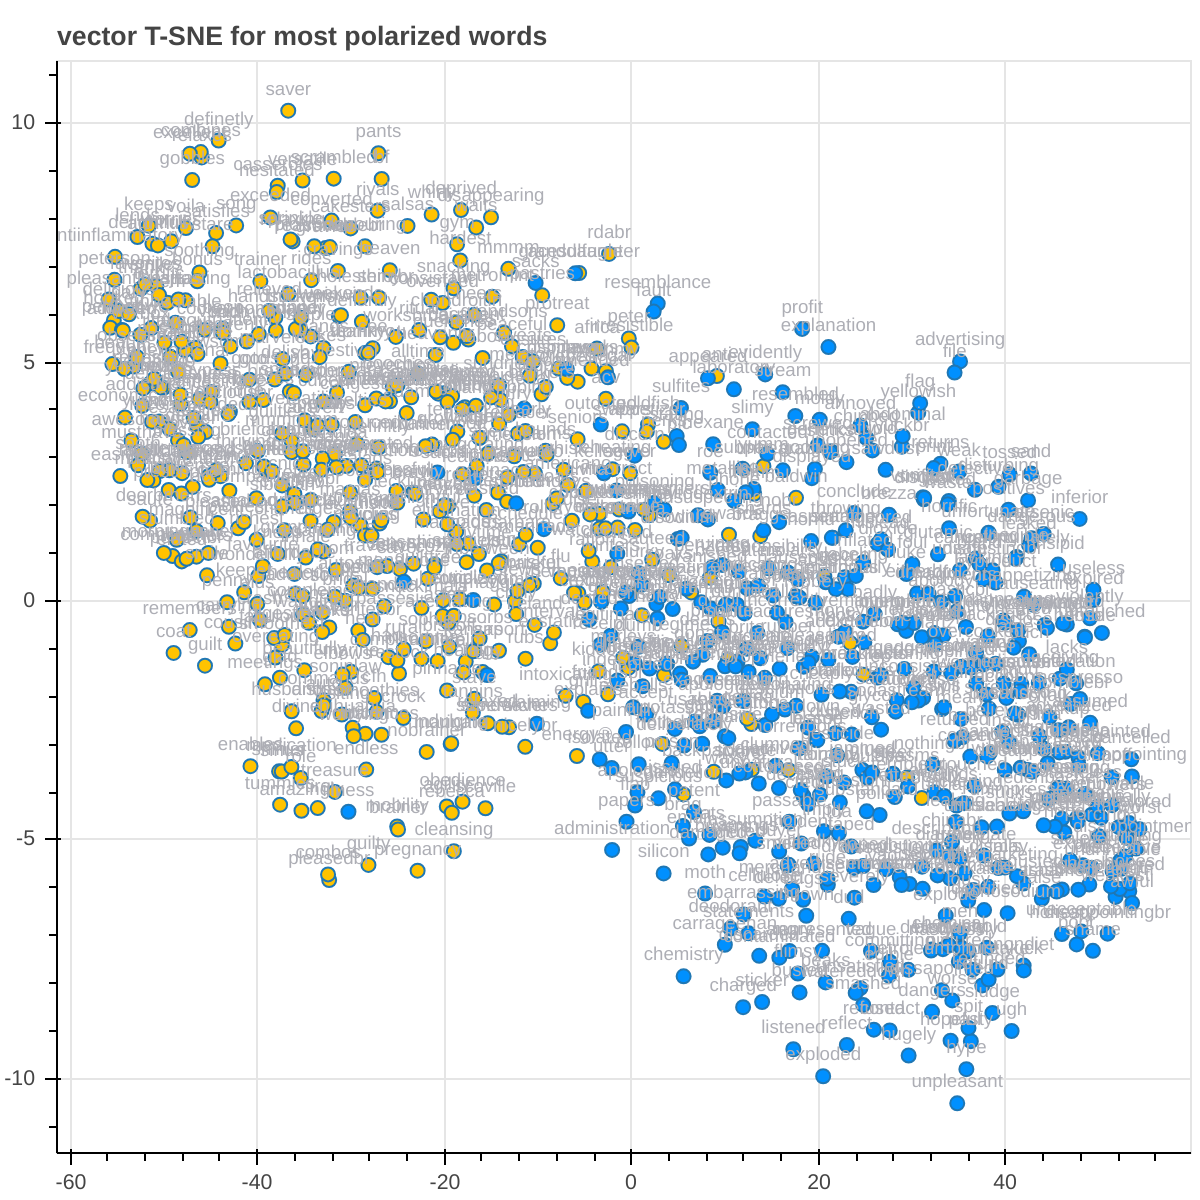

In [138]:
# for whole top 500 wor popultion
from IPython.display import Image
Image(filename='images/zoom_out_t-SNE_500_n.png') 


- The t-SNE plot in two dimension beautifully shows two blobs of word collections
- The intersection of this two mass meet at zero coordinate where polarity between words are smallest
- The color map which indicate the positive and negatove ratio of the words correlate well with this structures
- The more distance between the words (e.g. outer edges of two blobs) the more contrast in the meaning

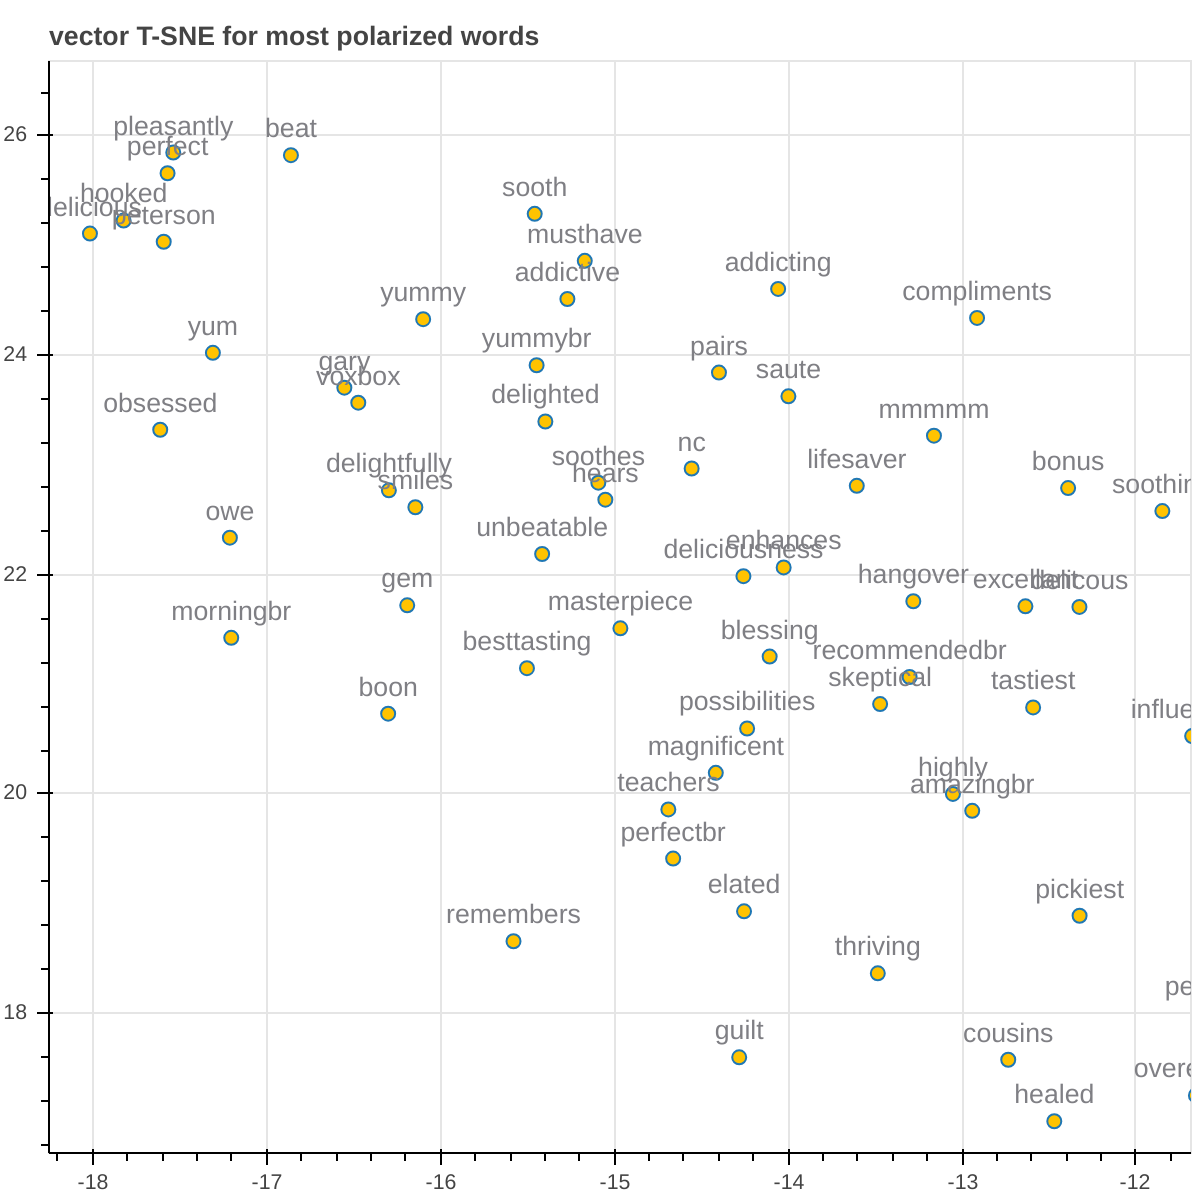

In [139]:
# zoom into positive structure considering 200 top words for better visulization close up
Image(filename='images/zoom_in_pos_t-SNE_200_n.png') 

- A closer look at t-SNE plot in postive region, shows words with similar meaning closer to gether

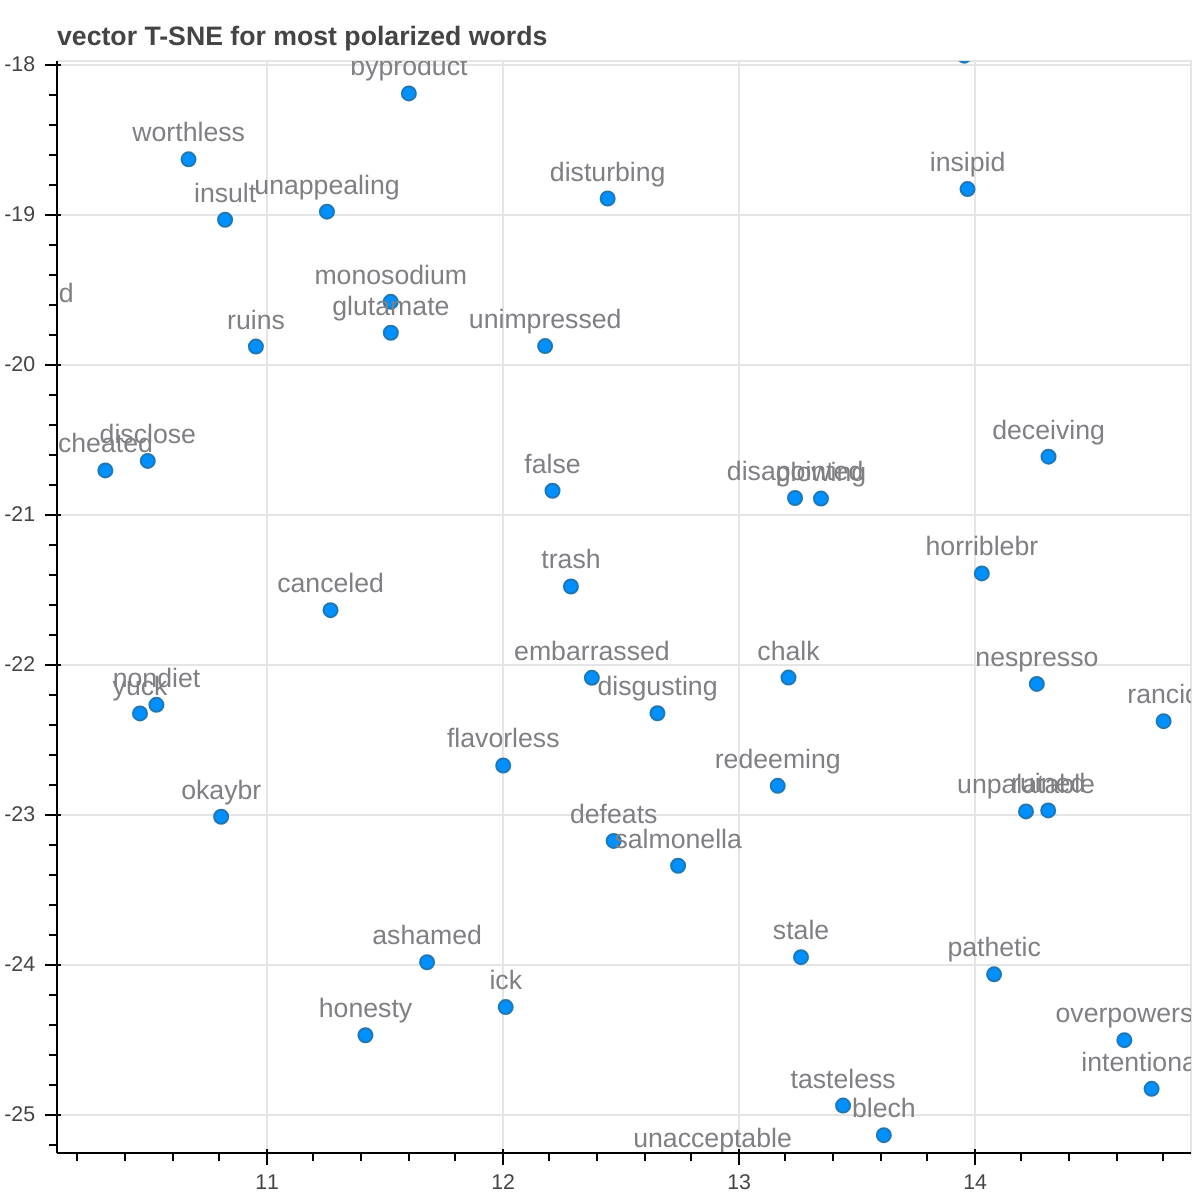

In [140]:
# zoom into negative structure considering 200 top words for better visulization close up
Image(filename='images/zoom_in_neg_t-SNE_200_n.png') 

- A closer look at t-SNE plot in negative region, shows words with similar meaning closer to gether

## Conclusion

- The analysis reveal two group of reviewers stand out in helpfulness to the community: First group are those who write long reviews, and second are the ones writing very frequent shorter reviews.

- The increase in the Amazon 5-start reviews after 2006 is alarming, that may indicate sign of abuse of the system. - In the past few years Amazon has introduced verified accounts, put more restriction on who is considered verified customers as well as introducing vine program. It would be interesting to see if these changes impact review score trend.

- The machine learning algorithm can successfully predict word sentiment of reviews that the model has not seen before with score ROC_AUC=0.95, Accuracy and F1_score of 0.9.

- The word structure created from embedding vectors after training the model clearly show two blob structure by unsupervised t-SNE representing sentiments (positive and negative) in the data.

- Considering various deep-learning approch tested in the process of completing this project (e.g. GRU, LSTM, 1D-Conv) the results did not improve significantly with adding deeper layer or changinf drop-out, due to alarming increase in 5-star reviews in Amazon data one approach is trying to screen these "fake" reviews by having information about the review submitter. This will hopefully improve the unbalanced nature of the reviews and perhaps the overall performance of the model.

**MIT License**

Copyright (C) 2020 Shalini Chandra

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.